In [72]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sklearn.set_config(display=”diagram”)

<font size=6>
    Sberbank Russian Housing Market
</font>

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>
<font color='red' size=5>
    The show so far ... 
</font>


**Summary**

1. Load data
2. Remove features
    * features missing more than 10%
    * features with high correlations to the other features
        * used hierarchical correlation dropper
3. Stage 1 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Scale num. features
        * perhaps better to wait until after 
            1. cat. encoding is done with ordinals
            2. imputation for (all) features
    * Cat. features
        * used Ordinal and OneHot-encoders
        * used custom encoder to include NANs
    * Retrieve column names        
    * Recast all features as needed
4. Stage 2 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Impute remaining features
        * Used `SimpleImputer`
        * `KNNImputer` failed
    * Retrieve column names
    * Recast all features as needed

5. Modeling

6. Evaluate errors

7. Feature importance

**TODOs**

0. Priorities
   1. Remove the target feature for the pipeline?
        * if the pipeline is fit for the independent features, then it should work with them alone;
        * whatever preprocessing is needed for the target feature can be done independently, outside of the pipeline 
   
1. $\checkmark$ ~~Get the columns names of the transformed data after the `Pipeline` / `ColumnTransformer` steps~~
    * _Needed for checking, further exploration, and featuring engineering_
2. Check on the appropriate strategies
    * $\checkmark$ ~~first do cat. encoding with `ColumnTransformer`, then do scaling on numericals in another `Pipeline`~~
    * ~~do everything in a single `Pipeline` taking care of the steps~~ $\to$ everything done with `ColumnTransformer` instead
        * allows individual selection of features for transformations
    * ~~Drop features with many unfilled values (can't do _after_ imputing) or just impute?, then pipeline~~ 
        * $\checkmark$ ~~Drop features with many unfilled values before/after preprocessing?~~
        * $\checkmark$ ~~impute afterwards~~
3. $\checkmark$ ~~Drop features which are mutually correlated; keep only the most relevant ones~~
    * **!!!** do this before first preprocessing stage?
4. More EDA
    * Identify quantities to be removed:
        * IDs which contribute to the spikes in the neg. tail of the 'price_doc' distribution
            * or see if they're correlated with another feature, like 'sub_area'
            * **UNFINISHED** 
                * wasn't an early sign that this was the case
                * is it possible to automatically detect narrow-bin spikes in a distribution? and eleminate the rows which contribute to them?
        * $\checkmark$ ~~check the distribution of the 'sub_area' feature~~
            * ~~are there enough samples for each category?~~ 
5. More feature engineering
    * There are a few more things which can be done to see if there's an improvement:
        * removing some IDs (rows) which have some outlier behavior (clearly defined spikes in distributions)
        * aggregating some features together (e.g. combining nearby 'sub_areas') $\to$ needs some ad hoc investigations
        * $\checkmark$ Using the classifiers to identify and reduce the number of features to only the important ones. $\to$ **TODO** need to save the results       
6. Try to package up the routine into a single stage with a multistep pipeline
    * The issue is keeping track of the columns since the stages work on different subsets;
    * An idea would be to
        1. Order the columns first by datatype
        2. Then do the structure-preserving transformations (transformations which preserve the number of columns) like scaling, ordinal encoding, imputing(?))
        3. Then do the transformations like OneHotEnc 

            
**Notes**
* All transforms were included with `ColumnTransformer`
    * selects cols individually
    * can act as a pipeline
    * retrieve the columns names and ordering
        * _this is important to do the next steps of processing_

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import os

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [6]:
#import importlib
import sys
sys.path.append('./helpers/')

## Load the data

In [86]:
df = pd.read_csv('../../datasets/sberbank-russian-housing-market/train.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [87]:
df.shape

(30471, 292)

Get the dtypes of the DF; save to a dict for later use

In [88]:
df_dtypes = df.dtypes.reset_index().rename(columns={'index':'column', 0:'datatype'})
df_dtype_dict = dict(zip(df_dtypes.column, df_dtypes.datatype.astype(str)))

### Feature work

#### Separate the target feature

**Note** the target feature may also need to be transformed, _e.g._ rescaled

In [89]:
target_feature = 'price_doc'
target_col = [target_feature]

In [92]:
df[target_col].head()

,price_doc
0,5850000
1,6000000
2,5700000
3,13100000
4,16331452


In [93]:
df_targ = df[target_col].copy()

In [97]:
df = df.drop(columns=target_feature)

#### Separate some features based on type and/or use

##### Identify the numerical features

In [98]:
ignore_cols = ['id','timestamp']

In [100]:
float_cols = df.drop(columns=ignore_cols).select_dtypes('float').columns.tolist()

int_cols = df.drop(columns=ignore_cols).select_dtypes('int').columns.tolist()

num_cols = df.drop(columns=ignore_cols).select_dtypes(['int', 'float']).columns.tolist()

Select the categorical features

In [101]:
string_cols = df.drop(columns=ignore_cols).select_dtypes('object').columns.tolist()

## Preprocess the data

### Drop features

#### Characterize the missing values

In [102]:
from helpers.fill_rates import get_column_fill_rates, get_row_fill_rates

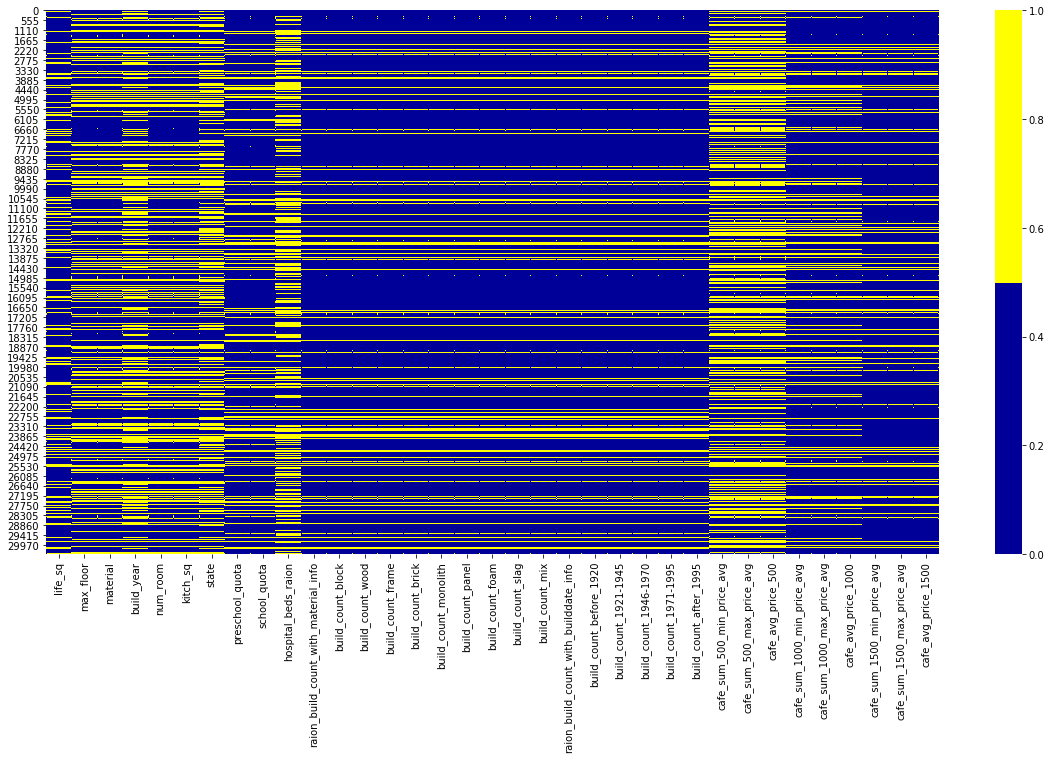

In [103]:
df_fillrates = get_column_fill_rates(df,0.0)
unfilled_cols = df_fillrates[df_fillrates['frac_full']<=0.90]['column_name'].tolist()

plt.figure(figsize=[20,10])
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[unfilled_cols].isnull().sample(frac=1).reset_index(drop=True), cmap=sns.color_palette(colours))

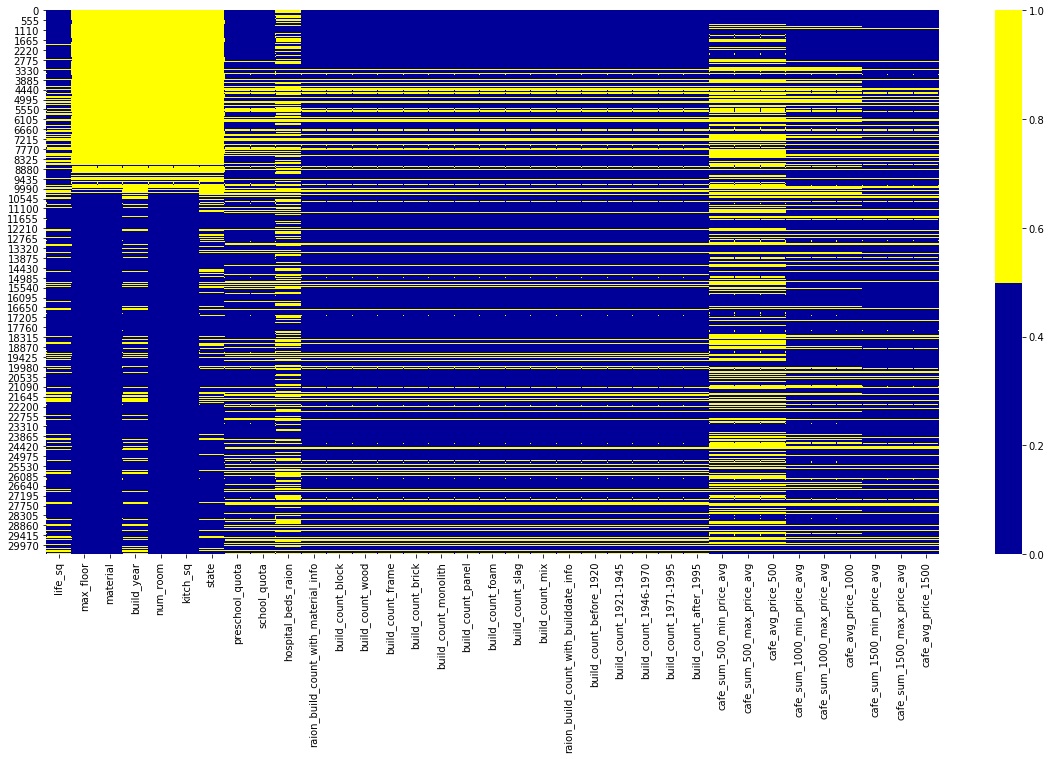

In [104]:
plt.figure(figsize=[20,10])
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[unfilled_cols].isnull().reset_index(drop=True), cmap=sns.color_palette(colours))

##### Check the fill rate of the features

Keep all features having more than 90% (arbitrary) of their values

In [105]:
threshold = 0.90
df_fillrates = get_column_fill_rates(df,threshold)
display(df_fillrates.sort_values("frac_full", ascending=True)[:10])

,column_name,frac_full
229,cafe_sum_2000_min_price_avg,0.943389
230,cafe_sum_2000_max_price_avg,0.943389
231,cafe_avg_price_2000,0.943389
252,cafe_sum_3000_min_price_avg,0.967477
254,cafe_avg_price_3000,0.967477
253,cafe_sum_3000_max_price_avg,0.967477
275,cafe_sum_5000_min_price_avg,0.990253
276,cafe_sum_5000_max_price_avg,0.990253
277,cafe_avg_price_5000,0.990253
269,prom_part_5000,0.994158


In [106]:
filled_cols = df_fillrates.column_name.tolist()
print(f'Number of features more than {round(100*threshold)}% filled: { len(filled_cols)}')

Number of features more than 90% filled: 256


##### Check the fill rate of the rows

**Note** this is passive; nothing is done with this info; it will also change when the unfilled features are removed

<font color='red' size=2>
    If this were applied, then the target_feature would need to be included (or matched by keeping the `id`)
</font>

In [107]:
threshold = 0.85
df_fillrates = get_row_fill_rates(df,threshold)
display(df_fillrates.sort_values("frac_full", ascending=True)[:10])

,id,row_counts,frac_full
3589,3589,248,0.852234
20231,20231,250,0.859107
5094,5094,250,0.859107
8474,8474,250,0.859107
7972,7972,250,0.859107
7172,7172,250,0.859107
7902,7902,250,0.859107
22097,22097,250,0.859107
5105,5105,250,0.859107
5277,5277,250,0.859107


In [108]:
print(f'Number of features more than {round(100*threshold)}% filled: { df_fillrates.shape[0]}')

Number of features more than 85% filled: 30470


##### Check the information content of the features

If the features contain little useful information (_ie_ they have low variance), they might not contribute much to the model. 
<br/>
For efficiecy reasons, it might be best to drop these, though the resulting model will likely be unchanged.

In [109]:
num_rows = len(df.index)
low_information_cols = [] #

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

oil_chemistry_raion: 99.02858%
no     30175
yes      296
Name: oil_chemistry_raion, dtype: int64

railroad_terminal_raion: 96.27187%
no     29335
yes     1136
Name: railroad_terminal_raion, dtype: int64

nuclear_reactor_raion: 97.16780%
no     29608
yes      863
Name: nuclear_reactor_raion, dtype: int64

big_road1_1line: 97.43691%
no     29690
yes      781
Name: big_road1_1line, dtype: int64

railroad_1line: 97.06934%
no     29578
yes      893
Name: railroad_1line, dtype: int64

cafe_count_500_price_high: 97.25641%
0    29635
1      787
2       38
3       11
Name: cafe_count_500_price_high, dtype: int64

mosque_count_500: 99.51101%
0    30322
1      149
Name: mosque_count_500, dtype: int64

cafe_count_1000_price_high: 95.52689%
0    29108
1     1104
2      145
3       51
4       39
5       15
6        8
7        1
Name: cafe_count_1000_price_high, dtype: int64

mosque_count_1000: 98.08342%
0    29887
1      584
Name: mosque_count_1000, dtype: int64

mosque_count_1500: 96.21936%
0    29

In [110]:
len(low_information_cols)

10

##### Dropping rows of cat. features with low representation

Consider dropping rows which contribute to the tail-end of features' distributions

(_Ideally, they would be outliers in several features, but this is difficult to check with no promise of a significant reward_)

In [111]:
num_rows = len(df.index)
low_rep_cat_cols = [] #

col = 'sub_area'
cnts = df[col].value_counts(dropna=False)
top_pct = (cnts/num_rows).iloc[0]

low_rep_cat_cols.append(col)
print('{0}: {1:.5f}%'.format(col, top_pct*100))
df_cnts = cnts.reset_index().rename(columns={'index':'sub_area', 'sub_area':'counts'})

sub_area: 5.82849%


In [112]:
df_cnts['%'] = df_cnts.counts.apply(lambda x: round(100.*x/num_rows,2))
df_cnts = df_cnts.sort_values('counts',ascending=False)

In [113]:
df_cnts.head(20)

,sub_area,counts,%
0,Poselenie Sosenskoe,1776,5.83
1,Nekrasovka,1611,5.29
2,Poselenie Vnukovskoe,1372,4.50
3,Poselenie Moskovskij,925,3.04
4,Poselenie Voskresenskoe,713,2.34
5,Mitino,679,2.23
6,Tverskoe,678,2.23
7,Krjukovo,518,1.70
8,Mar'ino,508,1.67
9,Poselenie Filimonkovskoe,496,1.63


In [114]:
csum = np.cumsum(df_cnts['%'].values)

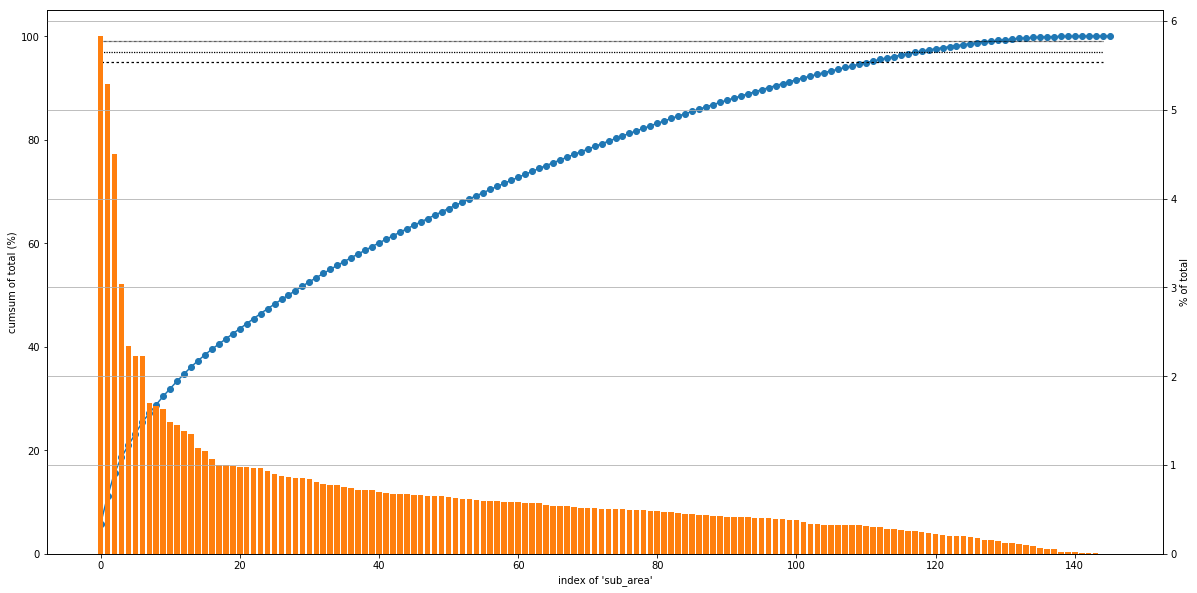

In [115]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
ax.plot(csum,'o-')
ax.plot([0,144],[99,99],'k--', dashes=[0.5,0.5], linewidth=1.25)
ax.plot([0,144],[97,97],'k--', dashes=[1.0,1.0], linewidth=1.25)
ax.plot([0,144],[95,95],'k--', dashes=[2.0,2.0], linewidth=1.25)
ax.set_ylabel('cumsum of total (%)')
ax.set_ylim(0,105)
ax1=ax.twinx()
ax1.bar(x=df_cnts.index, height=df_cnts['%'].values, color='C1')
ax1.set_ylabel('% of total')
ax1.grid()
ax.set_xlabel('index of \'sub_area\'');

In [116]:
cats_to_exclude = []
counts = 0
for n,r in df_cnts.sort_values('counts').iterrows():

    if counts/num_rows > 0.01:
        print(counts, counts/num_rows)
        break
    counts += r['counts']
    cats_to_exclude.append(r['sub_area'])

342 0.011223786551146992


In [117]:
print(len(cats_to_exclude))
print(cats_to_exclude)

18
['Poselenie Klenovskoe', 'Poselenie Mihajlovo-Jarcevskoe', 'Poselenie Kievskij', 'Poselenie Shhapovskoe', 'Molzhaninovskoe', 'Poselenie Marushkinskoe', 'Vostochnoe', 'Poselenie Voronovskoe', 'Arbat', 'Poselenie Mosrentgen', 'Poselenie Kokoshkino', 'Poselenie Krasnopahorskoe', 'Poselenie Rogovskoe', 'Poselenie Rjazanovskoe', 'Severnoe', "Krasnosel'skoe", 'Vnukovo', 'Kapotnja']


In [27]:
df_cnts[df_cnts['sub_area'].isin(cats_to_exclude)]

,sub_area,counts,%
128,Kapotnja,49,0.16
129,Vnukovo,44,0.14
130,Krasnosel'skoe,37,0.12
131,Severnoe,37,0.12
132,Poselenie Rjazanovskoe,34,0.11
133,Poselenie Rogovskoe,31,0.10
134,Poselenie Krasnopahorskoe,27,0.09
135,Poselenie Kokoshkino,20,0.07
136,Poselenie Mosrentgen,19,0.06
137,Arbat,15,0.05


**Notes** 

Strategies:
* drop the rows with these values $\to$ _means no prediction will be made for these!!!_
* combine these values into a new value, e.g. `'other'`
* (advanced) combine nearby regions of low counts into neighbors with higher counts

<font color='red' size=3>
    Warning: as above, if this were applied, then the target_feature would need to be included (or matched by keeping the `id`)
</font>

#### Correlation-based feature drop

In [118]:
from helpers.correlation_feature_drop import get_dropped_columns

In [119]:
threshold = 0.9

In [120]:
# Note: be sure to include the target feature in the correlation --> the current function requires it.
df_corr = df.drop(columns=ignore_cols+string_cols)
df_corr[target_feature] = df_targ
df_corr = df_corr.corr().abs()

In [121]:
drop_corr_cols = get_dropped_columns(df_corr, target_feature, threshold, False)

Index(['col1', 'col2', 'corr'], dtype='object')
Index(['col1', 'col2', 'corr', 'self', 'price_doc'], dtype='object')


#### Select the cols to keep

In [122]:
keep_cols = [c for c in df.columns.tolist() if (c in filled_cols) & (c not in drop_corr_cols + low_information_cols)]

In [123]:
df = df[keep_cols]
print(df.shape) #(30471, 116)
#df = df[df['sub_area'].isin(cats_to_exclude)==False].copy()
print(df.shape)

(30471, 105)
(30471, 105)


### Transformations

#### Inspect the categorical then do encoding

**Note** need to regrab the new set of string cols since some were dropped.

In [128]:
string_cols = df.drop(columns=ignore_cols).select_dtypes('object').columns.tolist()

In [129]:
print(string_cols)

['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'radiation_raion', 'big_market_raion', 'detention_facility_raion', 'water_1line', 'ecology']


In [130]:
df[string_cols].head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,radiation_raion,big_market_raion,detention_facility_raion,water_1line,ecology
0,Investment,Bibirevo,no,no,no,no,no,no,no,good
1,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,excellent
2,Investment,Tekstil'shhiki,no,no,no,yes,no,no,no,poor
3,Investment,Mitino,no,no,no,no,no,no,no,good
4,Investment,Basmannoe,no,no,no,yes,no,no,no,excellent


**Note**
* Ordinals:
    * 'ecology'
* OneHots
    * 'sub_area', 'product_type' (but only two vals)
* Binaries
    * the rest
    * _But these will also be considered ordinals_

In [131]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

import categorical_encoding
from categorical_encoding import OrdinalEncoderNans

onehot_cat_cols = ["sub_area", "product_type"]

ord4_cat_cols = ["ecology"]
ord4_cats = ['poor', 'satisfactory', 'good', 'excellent', 'no data'] # Normally, this is a nested list, ie [[1,2,3,...]]

ord2_cat_cols = [e for e in string_cols if (e not in onehot_cat_cols) & (e not in ord4_cat_cols) ]
ord2_cats = len(ord2_cat_cols)*[["no", "yes"]]

In [132]:
df[onehot_cat_cols].nunique()

sub_area        146
product_type      2
dtype: int64

In [133]:
onehot_sum = sum(df[onehot_cat_cols].nunique())

print(len(num_cols), len(onehot_cat_cols), len(ord2_cat_cols), len(ord4_cat_cols))
sum([len(num_cols), onehot_sum, len(ord2_cat_cols), len(ord4_cat_cols)])

274 2 7 1


430

#### Pipelines

##### Numerical features in a pipeline

**Note** could also use with the ColumnTransformer, like the cat. features, since is only one transform on the subset

In [134]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
# Use in ColumnTransformer as 
#   ("num_pipe",  num_pipeline, num_cols),


##### putting the cat-encs together into the pipeline

In [136]:
# Need to re-grab the numerics as well!
num_cols = df.drop(columns=ignore_cols).select_dtypes(['int', 'float']).columns.tolist()

In [137]:
pipeline_stage1 = ColumnTransformer([    
        ("ignored",   FunctionTransformer(lambda x: x), ignore_cols),
        #("target",  StandardScaler(), target_col),  
        ("num_cols",  StandardScaler(), num_cols),  
        ("onehots",   OneHotEncoder(sparse=False), onehot_cat_cols),
        ("ordinals2", OrdinalEncoder(ord2_cats), ord2_cat_cols),   
        ("ordinals4", OrdinalEncoderNans(ord4_cats), ord4_cat_cols),    
    ])

data = pipeline_stage1.fit_transform(df)

In [138]:
data.shape

(30471, 251)

In [139]:
df.shape

(30471, 105)

####  Retrieve the column names

This is a bit specific here, but generalizable

In [140]:
def get_transformed_column_names(pipeline_transformers):

    prepro_columns = []
    for line in pipeline_stage1.transformers_[:]:

        #print(type(line[1]).__name__ )
        if type(line[1]).__name__ == 'OneHotEncoder':
            # Note: can include old column identifiers in the OHE feature names
            #    with .get_feature_names(ohe_column_names)
            new_cols = line[1].get_feature_names().tolist()
            #print(line[0],'\t', len(new_cols))
            prepro_columns += new_cols
        else:
            new_cols = line[2]
            #print(line[0],'\t', len(new_cols))
            prepro_columns += new_cols    
            
    return prepro_columns

In [141]:
prepro_columns = get_transformed_column_names(pipeline_stage1.transformers_)

In [142]:
onehot_sum = sum(df[onehot_cat_cols].nunique())
check_col_lengths = [len(ignore_cols), len(target_col), len(num_cols), onehot_sum, len(ord2_cat_cols), len(ord4_cat_cols)]
print(*check_col_lengths)
print(sum(check_col_lengths), '==', len(prepro_columns))

2 1 93 148 7 1
252 == 251


#### Rebuild the DF and re-cast the data type

Prepare for the next pipeline: imputing

##### Rebuild the DF

In [143]:
df = pd.DataFrame(data=data, columns=prepro_columns)

##### Re-cast the data types

In [144]:
ignored_dtypes = [df_dtype_dict[c] for c in ignore_cols]

def set_dtypes(prepro_columns, nonfloat_dtypes):
    """Set a new dtype dict for the preprocessed df
    
    Args:
      prepro_columns ([str]): columns for the dict keys
      nonfloat_dtypes ([str]): datatypes for the non-float datatypes 
                               (assumes these are in the front of prepro_columns)

    Returns:
      dict: dictionary of column to datatype
    """

    nr_float_cols = len(prepro_columns)-len(nonfloat_dtypes)

    #### NOTE: all preprocess cols will now be floats
    dtypes_list = nonfloat_dtypes + (nr_float_cols)*['float']

    return dict(zip(prepro_columns, dtypes_list))    

In [145]:
dtypes_dict = set_dtypes(prepro_columns, ignored_dtypes)

In [146]:
len(dtypes_dict)

251

In [147]:
df = df.astype(dtypes_dict)

In [148]:
df.head()

,id,timestamp,full_sq,floor,area_m,green_zone_part,indust_part,school_education_centers_raion,school_education_centers_top_20_raion,healthcare_centers_raion,...,x1_Investment,x1_OwnerOccupier,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,radiation_raion,big_market_raion,detention_facility_raion,water_1line,ecology
0,1,2011-08-20,-0.294873,-0.690013,-0.544788,-0.166746,-1.000975,0.085621,-0.329044,-0.214951,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,2,2011-08-23,-0.531523,-0.877987,-0.390702,0.877732,-0.583340,0.956436,-0.329044,-0.214951,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,3,2011-08-27,-0.294873,-1.065960,-0.622239,-0.607483,-0.002814,0.666164,-0.329044,-0.214951,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,2011-09-01,0.914671,0.249854,-0.245700,-0.138328,-0.413849,1.536979,-0.329044,-0.214951,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,5,2011-09-05,0.599138,-0.690013,-0.448374,-1.163354,-0.687151,1.246708,-0.329044,1.794590,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0


## Second stage preprocessing

### Imputing

<font color='green' size=2> 
    Can this be organized with the above into a single pipeline?
    <br/>
    Possibly, since the following stage is an imputer
</font>

In [149]:
from sklearn.impute import SimpleImputer, KNNImputer

**Note** `KNNImputer` failed with a kernel restart. Memory? $\to$ try again

In [150]:
subprepro_columns = [c for c in prepro_columns if c not in ignore_cols + target_col]

In [152]:
pipeline_stage2 = ColumnTransformer([
        ("ignored",   FunctionTransformer(lambda x: x), ignore_cols),
        ('imputer', SimpleImputer(strategy='median'), subprepro_columns),    
    ])
 
####NOTE: still need to Scale the ordinalTransformed feature
data = pipeline_stage2.fit_transform(df)

### Rebuild the DF and re-cast the data type

In [153]:
#### NOTE: can use the same cols and dtypes as before since no further reordering of columns was made
df = pd.DataFrame(data=data, columns=prepro_columns).astype(dtypes_dict)

In [154]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 251 columns):
id                                       30471 non-null int64
timestamp                                30471 non-null datetime64[ns]
full_sq                                  30471 non-null float64
floor                                    30471 non-null float64
area_m                                   30471 non-null float64
green_zone_part                          30471 non-null float64
indust_part                              30471 non-null float64
school_education_centers_raion           30471 non-null float64
school_education_centers_top_20_raion    30471 non-null float64
healthcare_centers_raion                 30471 non-null float64
university_top_20_raion                  30471 non-null float64
sport_objects_raion                      30471 non-null float64
additional_education_raion               30471 non-null float64
shopping_centers_raion                   30471 non-nu

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

<font color='black' size=5>
    Modeling
</font>

In [156]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import model_selection, preprocessing

from sklearn.linear_model import LinearRegression

In [168]:
stasca = StandardScaler()

In [171]:
df_targ['price_doc'] = stasca.fit_transform(df_targ['price_doc'].values.reshape(-1, 1))

In [172]:
df_targ.head()

,price_doc
0,-0.266324
1,-0.234943
2,-0.297704
3,1.250402
4,1.926434


In [173]:
train, test, y_train, y_test = train_test_split(df.drop(["id", "timestamp"], axis=1), 
                                                df_targ, random_state=10, test_size=0.25)

In [174]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)
model.fit(train,y_train)
predictions = model.predict(test)

## Evaluation

### Errors

In [175]:
y_test.price_doc.min(), predictions.min()

(-1.4357715590882796, -1.0382938)

In [176]:
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc.min(), predictions.min()))
print(offset)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions+offset))
print("RMSLE: %f" % (rmsle))

1.4357715590882796
RMSLE: 0.217262


```
1.4720281209972588
RMSLE: 0.218097
```

From 14.05.2020
```
1.4357715590882796
RMSLE: 0.217262
```

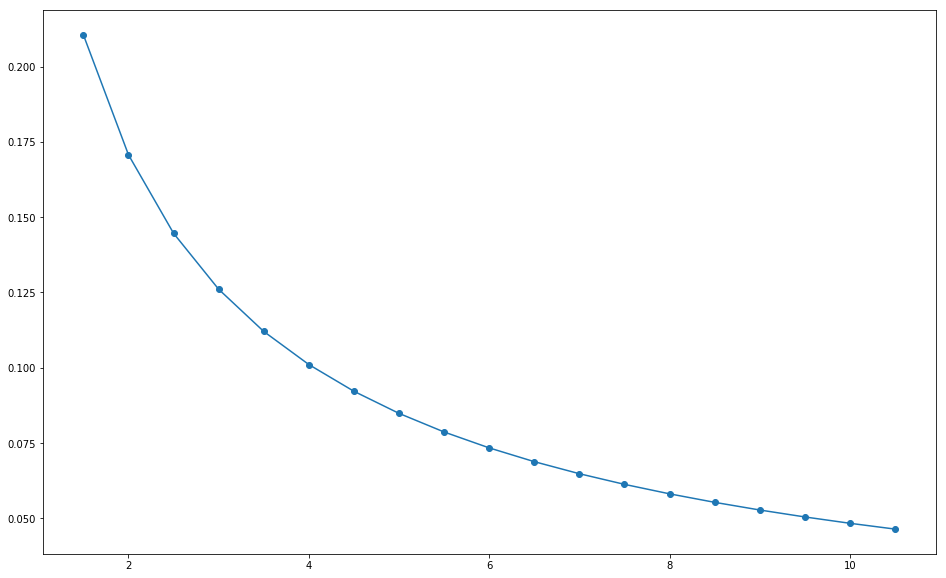

In [177]:
offsets = np.arange(1.5,11.0, 0.5)
errors = []
for x in offsets:
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+x, predictions+x))
    errors.append(rmsle)
errors = np.array(errors)

plt.figure(figsize=[16,10])
plt.plot(offsets, errors, 'o-')

### Distributions

In [178]:
predictions

array([-0.20246476, -0.5215992 ,  0.909094  , ..., -0.60221946,
       -0.7553015 ,  1.2092642 ], dtype=float32)

In [180]:
bin_width = 0.1
bins=np.arange(-2,12 + bin_width, bin_width)
hist_train, _ = np.histogram(y_train, bins=bins)
hist_test, _ = np.histogram(y_test, bins=bins)
hist_pred, _ = np.histogram(predictions, bins=bins)

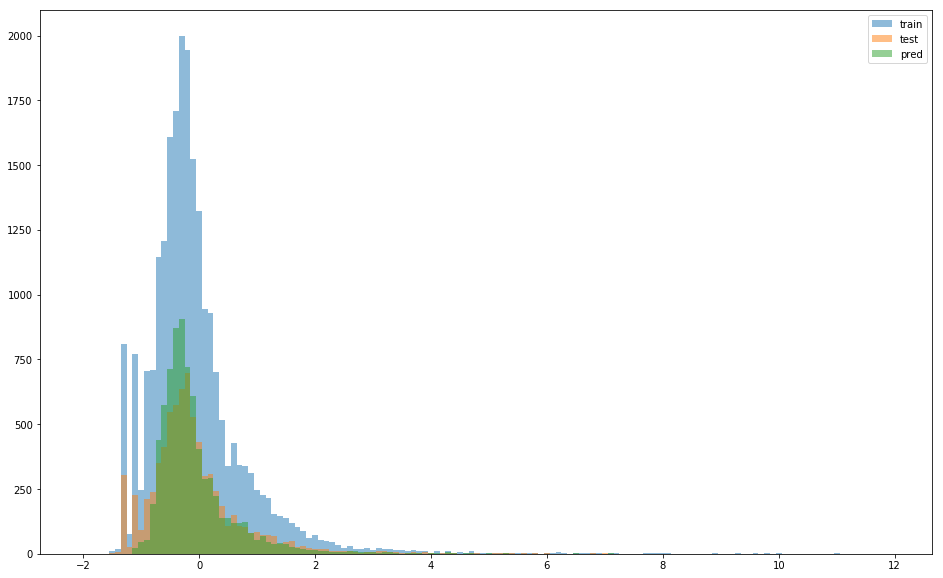

In [181]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

In [182]:
hist_train, _ = np.histogram(y_train, bins=bins, density=True)
hist_test, _ = np.histogram(y_test, bins=bins, density=True)
hist_pred, _ = np.histogram(predictions, bins=bins, density=True)

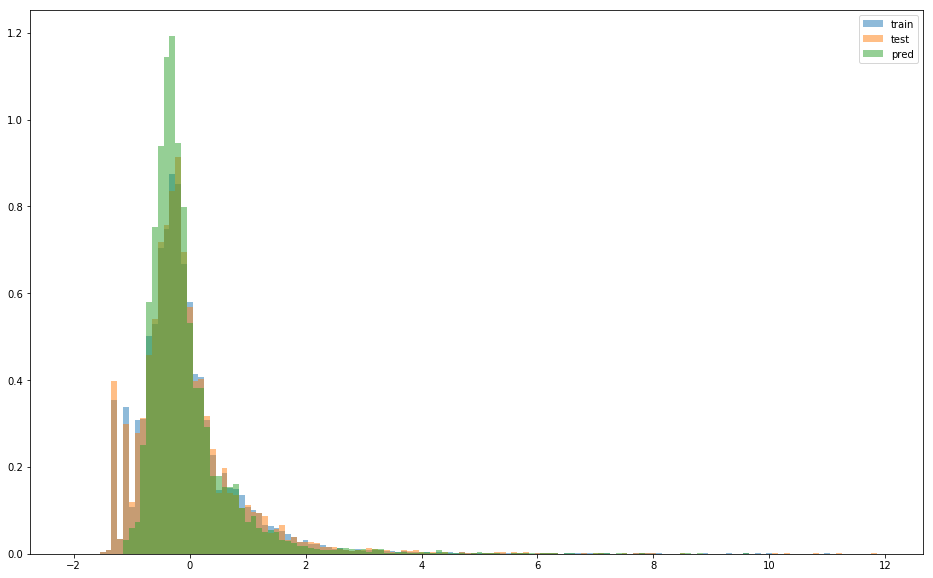

In [183]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

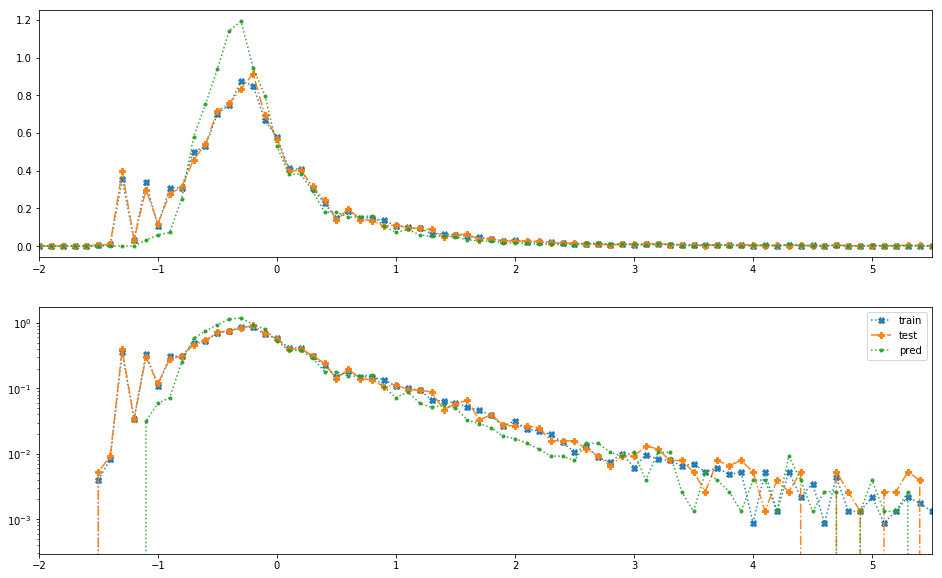

In [184]:
fig, ax = plt.subplots(2,1,figsize=[16,10])

ax =ax.reshape(2)

ax[0].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[0].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[0].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[0].set_xlim(-2.0,5.5)

ax[1].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[1].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[1].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[1].set_yscale('log')
ax[1].set_xlim(-2.0,5.5)
ax[1].legend();

### Feature importance

In [185]:
coeffs = model.fit(train,y_train).feature_importances_

In [186]:
df_co = pd.DataFrame(coeffs, columns=["importance_"])
df_co.index = train.columns
df_co.sort_values("importance_", ascending=True, inplace=True)
# Get relative importance
df_co['normed_importance_'] = df_co.importance_.apply(lambda x: x/df_co.importance_.max())

(165, 2)


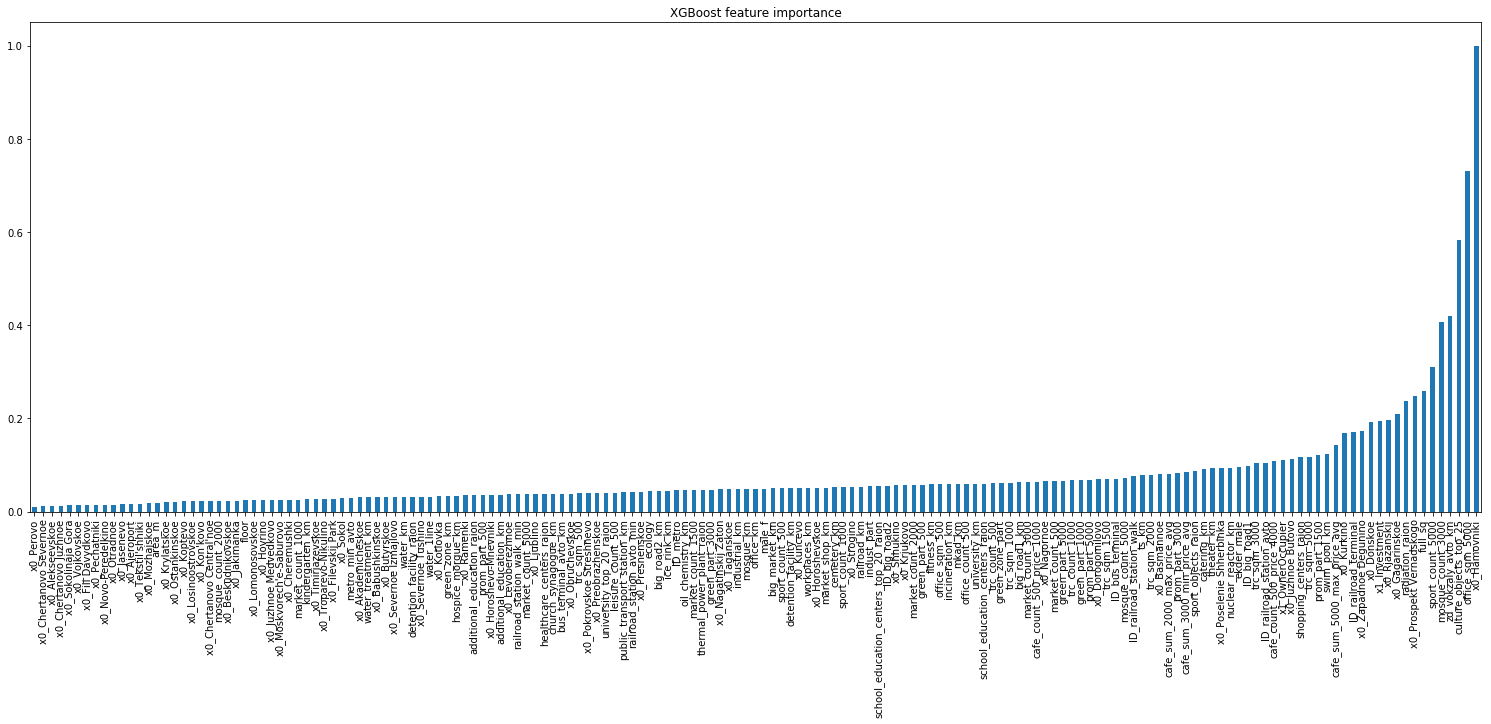

In [187]:
plt.figure(figsize=(26,9))
#df_co[df_co['importance_']>0.00175].importance_.plot(kind="bar")
df_co[df_co['normed_importance_']>0.01].normed_importance_.plot(kind="bar")
plt.title(f"XGBoost feature importance")
print(df_co[df_co['normed_importance_']>0.01].shape)

(165, 2)


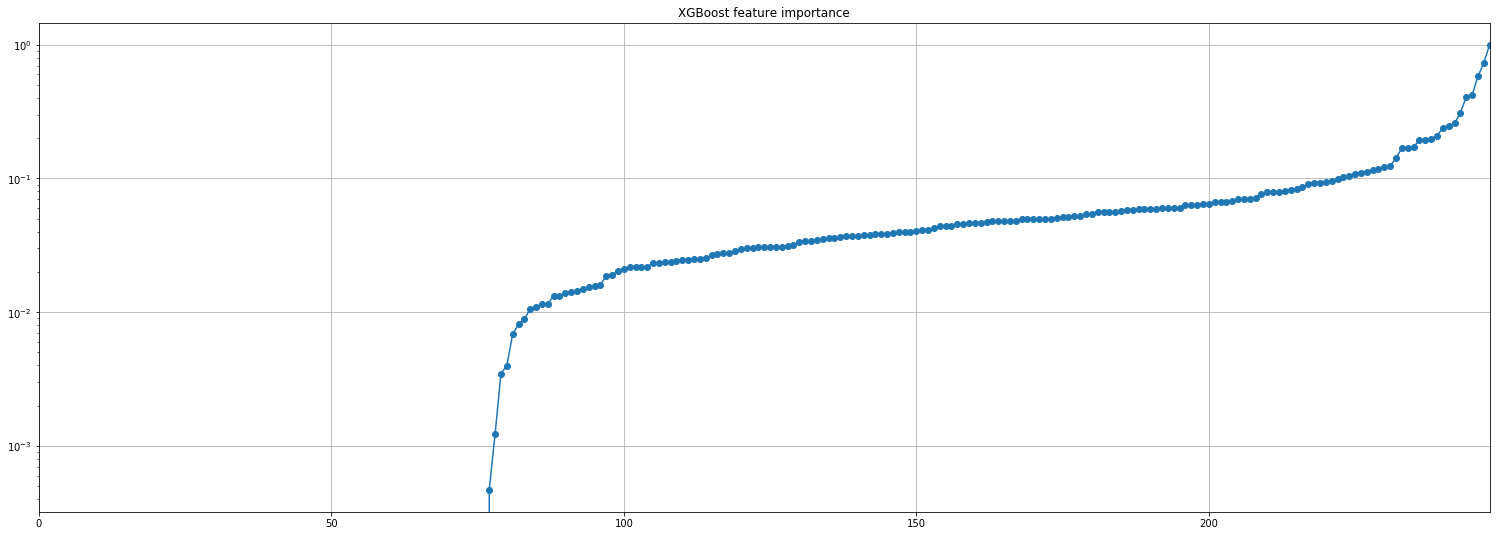

In [188]:
plt.figure(figsize=(26,9))
#df_co[df_co['importance_']>0.00175].importance_.plot(kind="bar")
df_co.reset_index().normed_importance_.plot(x='index',y='normed_importance', marker='o', linestyle='-')
plt.title(f"XGBoost feature importance")
plt.yscale('log')
plt.grid()
print(df_co[df_co['normed_importance_']>0.01].shape)


In [191]:
[c for c in df_co[df_co['normed_importance_']<0.01].reset_index()['index'].tolist()][:20]

['x0_Orehovo-Borisovo Juzhnoe',
 "x0_Sokol'niki",
 'x0_Arbat',
 'x0_Poselenie Kievskij',
 'x0_Begovoe',
 'x0_Bibirevo',
 'x0_Birjulevo Vostochnoe',
 'x0_Birjulevo Zapadnoe',
 'x0_Bogorodskoe',
 'x0_Brateevo',
 'x0_Danilovskoe',
 'x0_Solncevo',
 'x0_Staroe Krjukovo',
 'x0_Sviblovo',
 'x0_Dmitrovskoe',
 'x0_Poselenie Filimonkovskoe',
 "x0_Altuf'evskoe",
 'x0_Silino',
 'x0_Poselenie Klenovskoe',
 'x0_Poselenie Kokoshkino']

In [192]:
[c for c in df_co[df_co['normed_importance_']<0.01].reset_index()['index'].tolist() if 'x0_' not in c]

['incineration_raion', 'big_market_raion']

In [193]:
len([c for c in df_co[df_co['normed_importance_']<0.01].reset_index()['index'].tolist() if 'x0_' in c])

82

In [194]:
onehot_cats_as_cols = [c for c in prepro_columns if 'x0_' in c]

In [198]:
cats_to_exclude

['Poselenie Klenovskoe',
 'Poselenie Mihajlovo-Jarcevskoe',
 'Poselenie Kievskij',
 'Poselenie Shhapovskoe',
 'Molzhaninovskoe',
 'Poselenie Marushkinskoe',
 'Vostochnoe',
 'Poselenie Voronovskoe',
 'Arbat',
 'Poselenie Mosrentgen',
 'Poselenie Kokoshkino',
 'Poselenie Krasnopahorskoe',
 'Poselenie Rogovskoe',
 'Poselenie Rjazanovskoe',
 'Severnoe',
 "Krasnosel'skoe",
 'Vnukovo',
 'Kapotnja']

In [195]:
len(cats_to_exclude)

18

In [196]:
len([c for c in df_co[df_co['normed_importance_']<0.01].reset_index()['index'].tolist() if c.replace('x0_','') in cats_to_exclude]) 

18

#### Compare SV-spec. with XGB's feature importance

In [244]:
train.shape

(22853, 259)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=259)

X_pca = pca.fit_transform(train)

sing_vals = pca.singular_values_

In [259]:
df_co.reset_index().sort_values('normed_importance_', ascending=False).head()

,index,importance_,normed_importance_
258,x0_Hamovniki,0.059068,1.000000
257,x0_Danilovskoe,0.057126,0.967132
256,office_sqm_5000,0.052846,0.894668
255,x0_Donskoe,0.036848,0.623820
254,mosque_count_3000,0.036521,0.618290


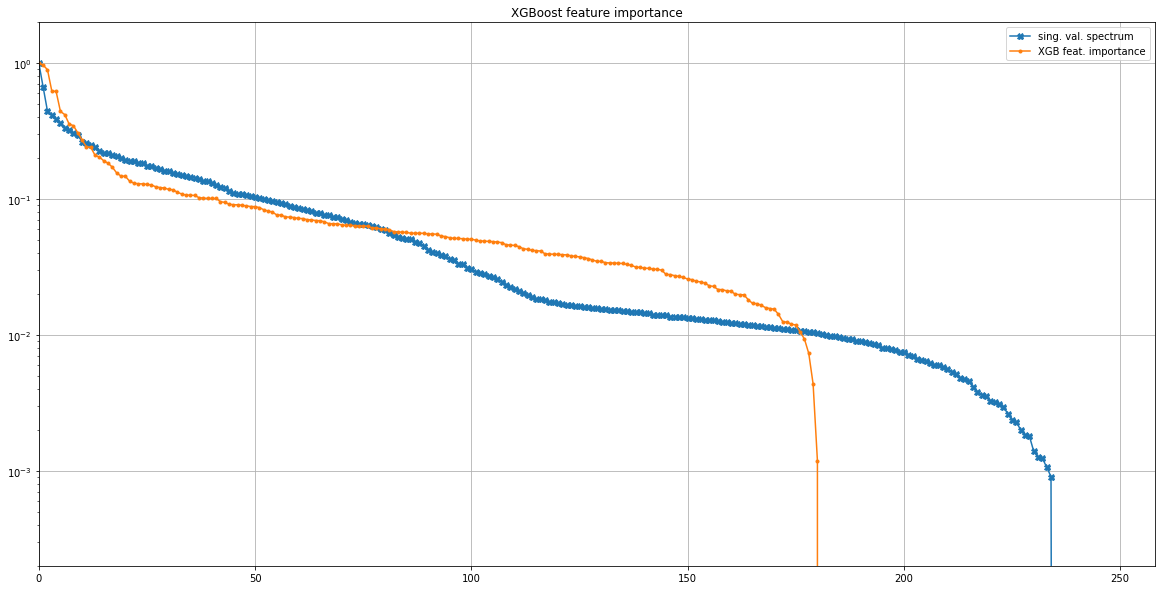

In [329]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(np.arange(len(sing_vals)),sing_vals/sing_vals[0], marker='X', label='sing. val. spectrum')
df_co.sort_values('normed_importance_', ascending=False).reset_index().plot(y='normed_importance_', marker='.', linestyle='-', ax=ax, label='XGB feat. importance')
plt.title(f"XGBoost feature importance")
plt.yscale('log')
plt.grid()

plt.ylim(2e-4,2)
plt.legend();

<font color='red' size=5>
    Stop!
</font>
<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>

In [55]:
df_test = pd.read_csv('../../datasets/sberbank-russian-housing-market/test.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])


In [83]:
df_test.shape

(7662, 291)

In [64]:
df_dtypes = df_test.dtypes.reset_index().rename(columns={'index':'column', 0:'datatype'})
dict(zip(df_dtypes.column, df_dtypes.datatype.astype(str)))

{'id': 'int64',
 'timestamp': 'datetime64[ns]',
 'full_sq': 'float64',
 'life_sq': 'float64',
 'floor': 'int64',
 'max_floor': 'int64',
 'material': 'int64',
 'build_year': 'float64',
 'num_room': 'int64',
 'kitch_sq': 'float64',
 'state': 'float64',
 'product_type': 'object',
 'sub_area': 'object',
 'area_m': 'float64',
 'raion_popul': 'int64',
 'green_zone_part': 'float64',
 'indust_part': 'float64',
 'children_preschool': 'int64',
 'preschool_quota': 'float64',
 'preschool_education_centers_raion': 'int64',
 'children_school': 'int64',
 'school_quota': 'float64',
 'school_education_centers_raion': 'int64',
 'school_education_centers_top_20_raion': 'int64',
 'hospital_beds_raion': 'float64',
 'healthcare_centers_raion': 'int64',
 'university_top_20_raion': 'int64',
 'sport_objects_raion': 'int64',
 'additional_education_raion': 'int64',
 'culture_objects_top_25': 'object',
 'culture_objects_top_25_raion': 'int64',
 'shopping_centers_raion': 'int64',
 'office_raion': 'int64',
 'therma

<font color='red' size=5>
    Stop!
</font>
<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>

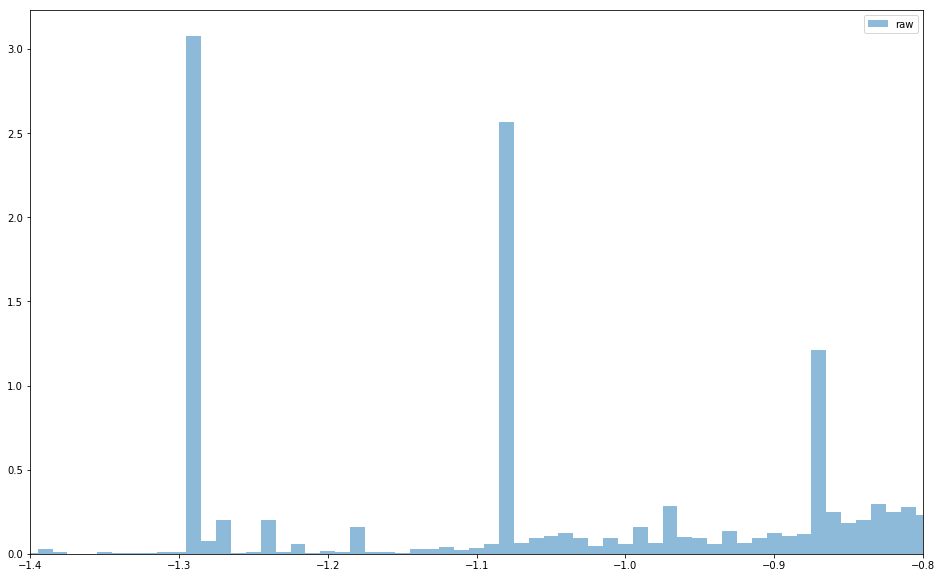

In [65]:
bin_width = 0.01
bins=np.arange(-2,12 + bin_width, bin_width)
hist_df_price_doc, _ = np.histogram(df.price_doc.values, bins=bins, density=True)

fig, ax = plt.subplots(1,1,figsize=[16,10])
#ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_df_price_doc, width=bin_width, label='raw', alpha=0.5)
ax.set_xlim(-1.4, -0.8)
ax.legend();

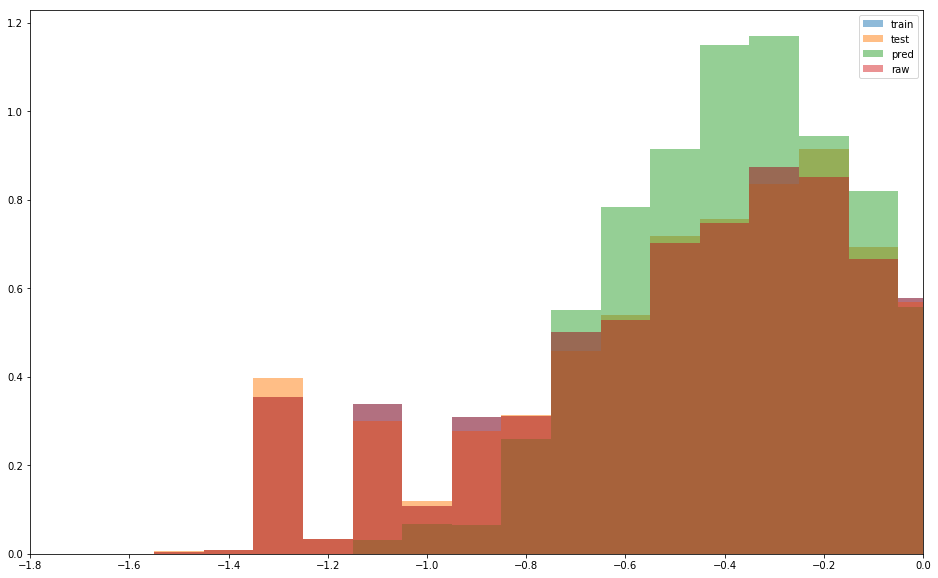

In [56]:
fig, ax = plt.subplots(1,1,figsize=[16,10])
ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='raw', alpha=0.5)
ax.set_xlim(-1.8, 0)
ax.legend();

In [371]:
df_spikes = pd.read_csv('../../datasets/sberbank-russian-housing-market/train.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])[['id','sub_area', 'price_doc']]

In [374]:
df_copy = df_spikes.copy()

In [375]:
df_copy.replace(to_replace='Bibirevo',value=np.nan,inplace=True)

In [384]:
df_copy.count(axis=1).reset_index().rename(columns={'index':'id', 0:'row_counts'})

,id,row_counts
0,0,2
1,1,3
2,2,3
3,3,3
4,4,3
5,5,3
6,6,3
7,7,2
8,8,3
9,9,3


In [177]:
from sklearn.preprocessing import StandardScaler

stasca = StandardScaler()

In [178]:
df_spikes['scaled_price_doc'] = stasca.fit_transform(df_spikes.price_doc.values.reshape(-1,1))

In [180]:
df_left3_spike = df_spikes[(-1.3 < df_spikes['scaled_price_doc']) & (df_spikes['scaled_price_doc'] < -1.27)]
print(df_left3_spike.shape)

df_left2_spike = df_spikes[(-1.09 < df_spikes['scaled_price_doc']) & (df_spikes['scaled_price_doc'] < -1.05)]
print(df_left2_spike.shape)

df_left1_spike = df_spikes[(-0.9 < df_spikes['scaled_price_doc']) & (df_spikes['scaled_price_doc'] < -0.85)]
print(df_left1_spike.shape)

(965, 4)
(847, 4)
(550, 4)


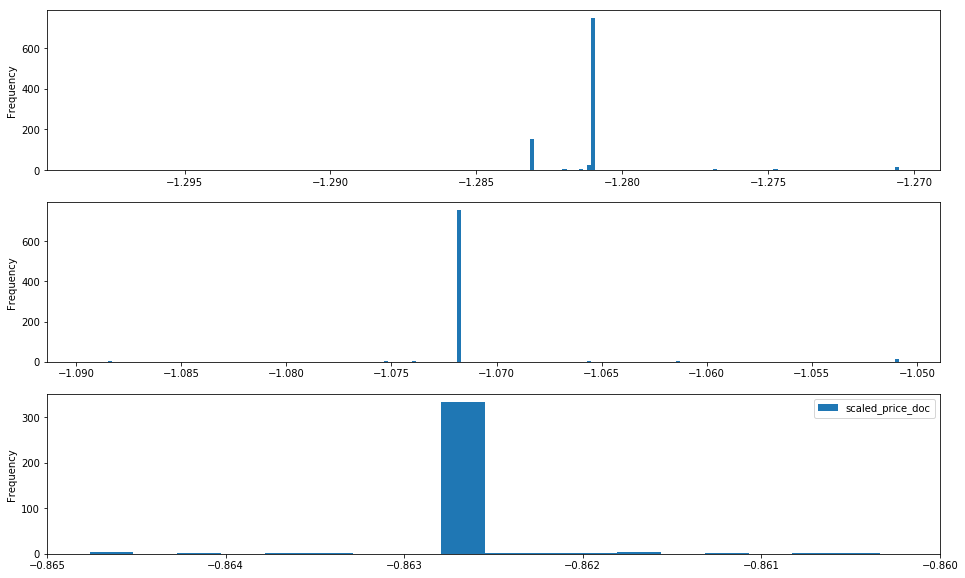

In [183]:
fig, ax = plt.subplots(3,1,figsize=[16,10])
ax=ax.reshape(3)
df_left3_spike.scaled_price_doc.plot.hist(bins=200, ax=ax[0])
df_left2_spike.scaled_price_doc.plot.hist(bins=200, ax=ax[1])
df_left1_spike.scaled_price_doc.plot.hist(bins=200, ax=ax[2])
plt.legend();

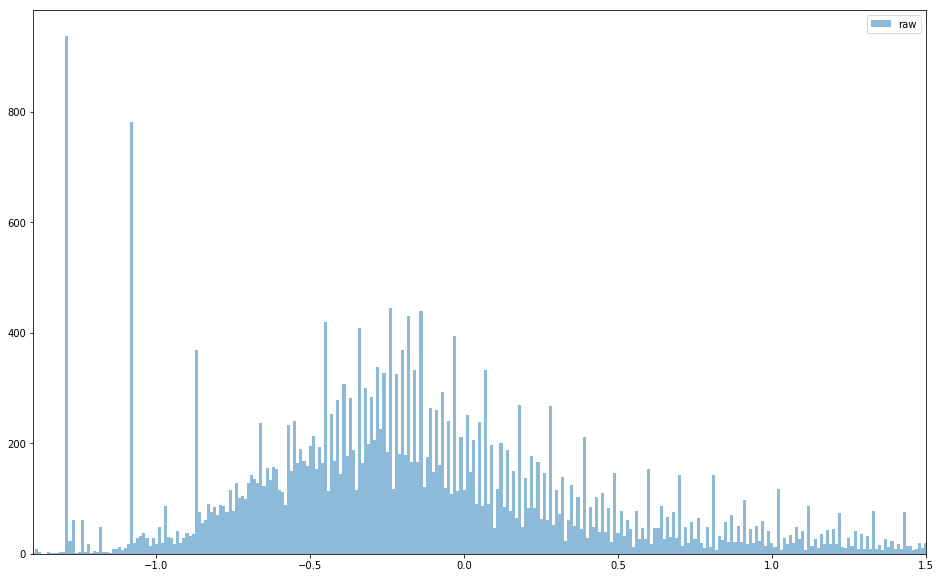

In [167]:
bin_width = 0.01
bins=np.arange(-2,12 + bin_width, bin_width)
hist_dfsa_price_doc, _ = np.histogram(df_spikes.scaled_price_doc.values, bins=bins, density=False)

fig, ax = plt.subplots(1,1,figsize=[16,10])
#ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_dfsa_price_doc, width=bin_width, label='raw', alpha=0.5)
ax.set_xlim(-1.4, 1.5)
ax.legend();

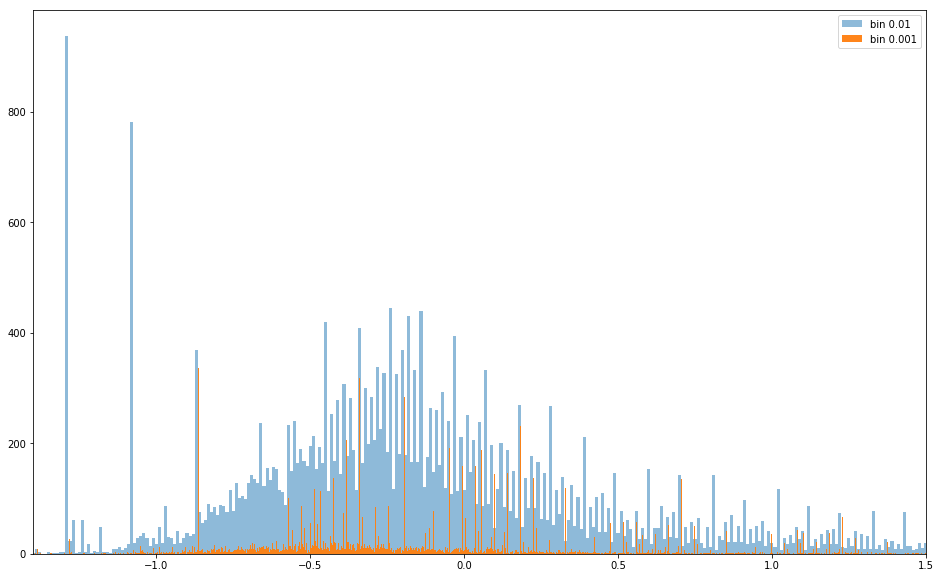

In [174]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

bin_width = 0.01
bins=np.arange(-2,12 + bin_width, bin_width)
hist_dfsa_price_doc, _ = np.histogram(df_spikes.scaled_price_doc.values, bins=bins, density=False)

ax.bar( x=bins[:-1],height=hist_dfsa_price_doc, width=bin_width, label=f'bin {bin_width}', alpha=0.5)


bin_width2 = 0.001
bins2=np.arange(-1.5,1.5 + bin_width2, bin_width2)
hist_dfsa_price_doc2, _ = np.histogram(df_spikes.scaled_price_doc.values, bins=bins2, density=False)

ax.bar( x=bins2[:-1],height=hist_dfsa_price_doc2, width=bin_width2, label=f'bin {bin_width2}', alpha=0.95)
#ax.set_xlim(-1.5, 1.5)
ax.set_xlim(-1.4, 1.5)
ax.legend();

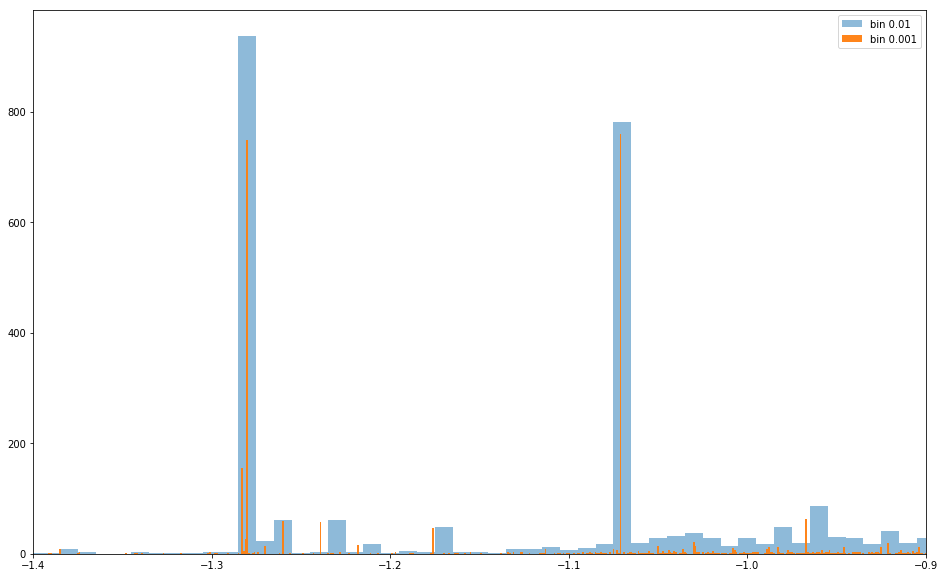

In [177]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[1:],height=hist_dfsa_price_doc, width=bin_width, label=f'bin {bin_width}', alpha=0.5)

ax.bar( x=bins2[1:],height=hist_dfsa_price_doc2, width=bin_width2, label=f'bin {bin_width2}', alpha=0.95)

ax.set_xlim(-1.4, -0.9)
ax.legend();

In [87]:
sub_area_ohe_cols = [c for c in df_left2_spike.columns if "x0" in c]

In [149]:
df_spikes = df_spikes.drop(columns=['price_doc', 'scaled_price_doc'])

In [118]:
df_sa_grp = df_spikes.groupby('sub_area').count().reset_index().sort_values('id', ascending=False).rename(columns={'id':'count'}).reset_index(drop=True)
count_sum = df_sa_grp['count'].sum()
df_sa_grp['frac'] = df_sa_grp['count'].apply(lambda x: x/count_sum)

In [119]:
df_sa_grp.head()

,sub_area,count,frac
0,Poselenie Sosenskoe,1776,0.058285
1,Nekrasovka,1611,0.052870
2,Poselenie Vnukovskoe,1372,0.045026
3,Poselenie Moskovskij,925,0.030357
4,Poselenie Voskresenskoe,713,0.023399


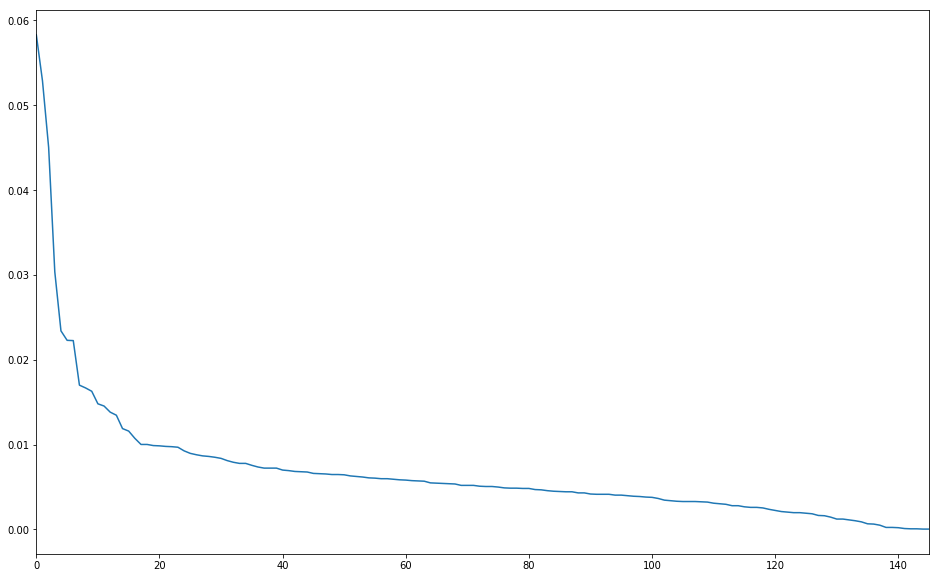

In [120]:
plt.figure(figsize=[16,10])
df_sa_grp.frac.plot()

In [ ]:
df_sa_grp_l3 = df_spikes.merge(df_left3_spike.id, on='id', how='inner')\
    .groupby('sub_area').count().reset_index()\
    .sort_values('id', ascending=False)\
    .rename(columns={'id':'count'}).reset_index(drop=True)
count_sum_l3 = df_sa_grp_l3['count'].sum()
df_sa_grp_l3['frac'] = df_sa_grp_l3['count'].apply(lambda x: x/count_sum_l3)

In [131]:
df_sa_grp_l2 = df_spikes.merge(df_left2_spike.id, on='id', how='inner')\
    .groupby('sub_area').count().reset_index()\
    .sort_values('id', ascending=False)\
    .rename(columns={'id':'count'}).reset_index(drop=True)
count_sum_l2 = df_sa_grp_l2['count'].sum()
df_sa_grp_l2['frac'] = df_sa_grp_l2['count'].apply(lambda x: x/count_sum_l2)

In [132]:
df_sa_grp_l1 = df_spikes.merge(df_left1_spike.id, on='id', how='inner')\
    .groupby('sub_area').count().reset_index()\
    .sort_values('id', ascending=False)\
    .rename(columns={'id':'count'}).reset_index(drop=True)
count_sum_l1 = df_sa_grp_l1['count'].sum()
df_sa_grp_l1['frac'] = df_sa_grp_l1['count'].apply(lambda x: x/count_sum_l1)

In [133]:
df_sa_grp_jn = df_sa_grp.merge(   df_sa_grp_l1, on='sub_area',how='left', suffixes=['','_l1'])
df_sa_grp_jn = df_sa_grp_jn.merge(df_sa_grp_l2, on='sub_area',how='left', suffixes=['','_l2'])
df_sa_grp_jn = df_sa_grp_jn.merge(df_sa_grp_l3, on='sub_area',how='left', suffixes=['','_l3'])

In [134]:
df_sa_grp_jn.head()

,sub_area,count,frac,count_l1,frac_l1,count_l2,frac_l2,count_l3,frac_l3
0,Poselenie Sosenskoe,1776,0.058285,27.0,0.049091,4.0,0.004723,1.0,0.001036
1,Nekrasovka,1611,0.052870,3.0,0.005455,8.0,0.009445,7.0,0.007254
2,Poselenie Vnukovskoe,1372,0.045026,4.0,0.007273,1.0,0.001181,NaN,NaN
3,Poselenie Moskovskij,925,0.030357,5.0,0.009091,4.0,0.004723,NaN,NaN
4,Poselenie Voskresenskoe,713,0.023399,2.0,0.003636,1.0,0.001181,NaN,NaN


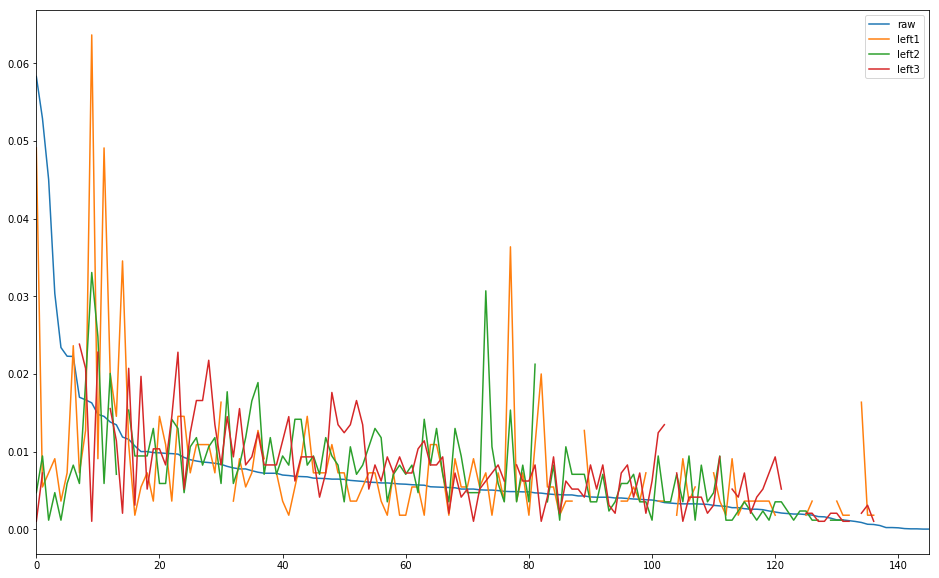

In [138]:
plt.figure(figsize=[16,10])
df_sa_grp_jn.frac.plot(label='raw')
df_sa_grp_jn.frac_l1.plot(label='left1')
df_sa_grp_jn.frac_l2.plot(label='left2')
df_sa_grp_jn.frac_l3.plot(label='left3')
plt.legend()


<font color='red' size=5>
    Stop!
</font>
<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>

### Expanding on the Important Features selected by the classifiers

**Notes**
* only some estimators have this
* **TODO** what does the "importance" score mean?

#### Try first with XGBoost

In [464]:
import xgboost as xgb

1. Set up the data: remove `id` and target feature, `price_doc`

In [469]:
X = df.filter(all_full_cols, axis=1).select_dtypes(include='number').drop(["id", "price_doc"], axis=1).copy()
y = df.filter(all_full_cols, axis=1).price_doc.values

2. Run XGB's feature importance method (internal)

In [472]:
clf = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1)
coeffs = clf.fit(X, y).feature_importances_

3. Save to DF

In [483]:
df_co = pd.DataFrame(coeffs, columns=["importance_"])
df_co.index = X.columns
df_co.sort_values("importance_", ascending=True, inplace=True)
# Get relative importance
df_co['normed_importance_'] = df_co.importance_.apply(lambda x: x/df_co.importance_.max())

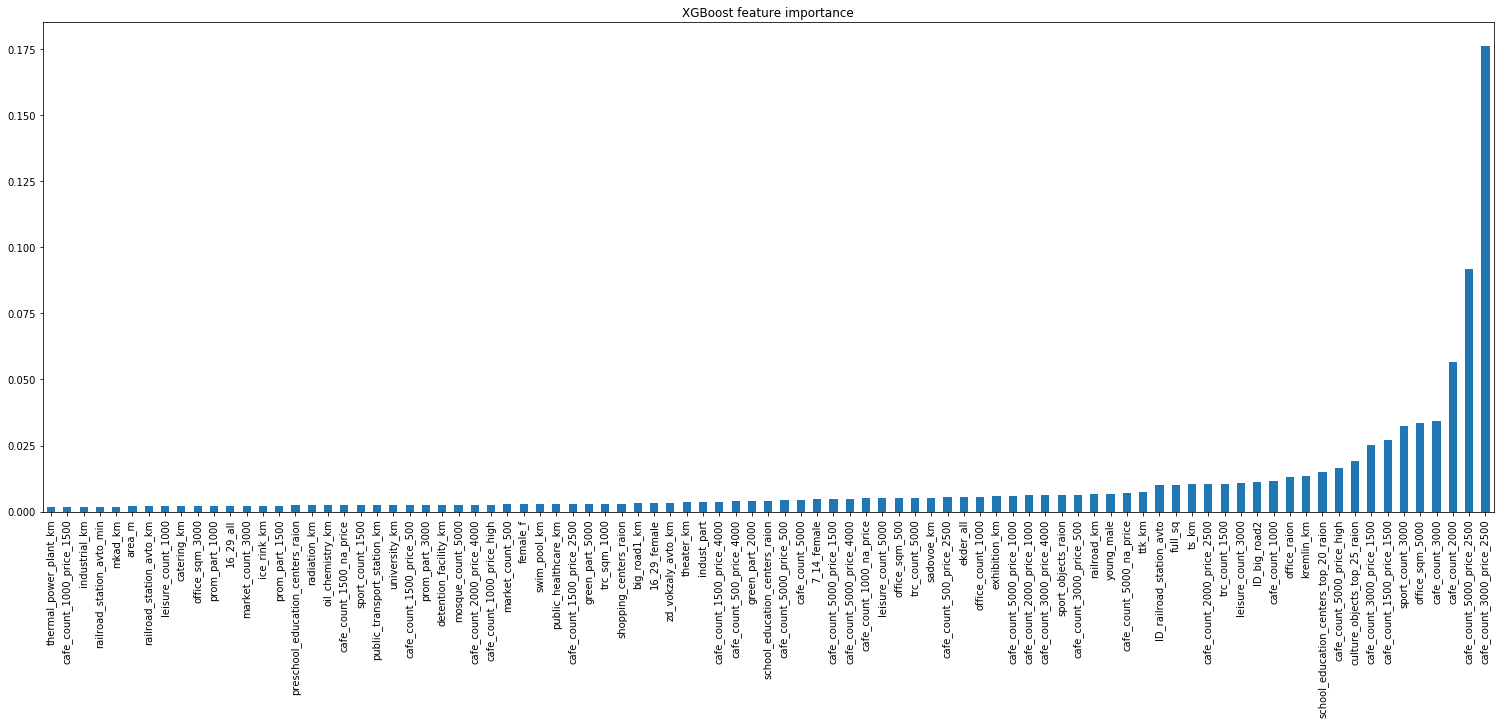

In [484]:
plt.figure(figsize=(26,9))
#df_co[df_co['importance_']>0.00175].importance_.plot(kind="bar")
df_co[df_co['normed_importance_']>0.01].importance_.plot(kind="bar")
plt.title(f"XGBoost feature importance")
plt.show()

#### Try with other ensemple regressors

In [507]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

import lightgbm as lgb

In [511]:
classifiers = [
               RandomForestRegressor(),
               GradientBoostingRegressor(),
               AdaBoostRegressor(),
               lgb.LGBMRegressor(),
               xgb.XGBRegressor(objective="reg:squarederror"),
]

clf_names = ["rfo","gbm", "ada", "lgb", "xgb"];

1. Compute the feature importance with the classifiers
    * using defaults (some from `sklearn`; `xgb` and `lgb` are their own)

In [512]:
n=0
pdf_co = pd.DataFrame()
for clf_name, clf in zip(clf_names, classifiers):
    print(clf_name)
    %time coeffs = clf.fit(X, y).feature_importances_
    df_co = pd.DataFrame(coeffs, columns=["importance_"+clf_name.strip()])
    df_co.index = X.columns
    print(df_co.shape)
    pdf_co = pd.concat([pdf_co, df_co], axis=1)
    print(df_co.shape, pdf_co.shape)    
    n+=1

rfo
CPU times: user 6min 23s, sys: 316 ms, total: 6min 23s
Wall time: 6min 24s
(237, 1)
(237, 1) (237, 1)
gbm
CPU times: user 1min 25s, sys: 77.9 ms, total: 1min 25s
Wall time: 1min 25s
(237, 1)
(237, 1) (237, 2)
ada
CPU times: user 35.5 s, sys: 1.18 s, total: 36.7 s
Wall time: 36.7 s
(237, 1)
(237, 1) (237, 3)
lgb
CPU times: user 6.06 s, sys: 103 ms, total: 6.16 s
Wall time: 6.18 s
(237, 1)
(237, 1) (237, 4)
xgb
CPU times: user 39.6 s, sys: 74.3 ms, total: 39.6 s
Wall time: 39.7 s
(237, 1)
(237, 1) (237, 5)


In [514]:
pdf_co.head()

,importance_rfo,importance_gbm,importance_ada,importance_lgb,importance_xgb
full_sq,0.427127,0.567171,0.260874,526,0.010191
area_m,0.001799,0.001995,0.000238,5,0.001914
raion_popul,0.000463,0.000000,0.000000,2,0.001127
green_zone_part,0.002540,0.005377,0.016906,14,0.001718
indust_part,0.002373,0.005299,0.002924,19,0.003689


In [518]:
pdf_co.describe()

,importance_rfo,importance_gbm,importance_ada,importance_lgb,importance_xgb,normed_importance_rfo,normed_importance_gbm,normed_importance_ada,normed_importance_lgb,normed_importance_xgb
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,0.004219,0.004219,0.004219,12.658228,0.004219,0.009879,0.007439,0.016174,0.024065,0.023925
std,0.027923,0.037266,0.018474,35.286438,0.014040,0.065373,0.065704,0.070816,0.067084,0.079610
min,0.000001,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000
25%,0.000499,0.000000,0.000000,2.000000,0.000683,0.001168,0.000000,0.000000,0.003802,0.003873
50%,0.001207,0.000170,0.000000,7.000000,0.001394,0.002826,0.000300,0.000000,0.013308,0.007903
75%,0.003108,0.001000,0.002869,14.000000,0.002694,0.007276,0.001763,0.010998,0.026616,0.015273
max,0.427127,0.567171,0.260874,526.000000,0.176361,1.000000,1.000000,1.000000,1.000000,1.000000


2. Normalized the `feature_importance` cols
    * Don't know what this means for the relative importance

In [516]:
all_cols = ['importance_' + e for e in clf_names]
new_all_cols = []
for col in all_cols:
    new_col = 'normed_' + col
    pdf_co[new_col] = pdf_co[col].apply(lambda x: x/pdf_co[col].max())
    new_all_cols.append(new_col)

3. Plot the results for comparison

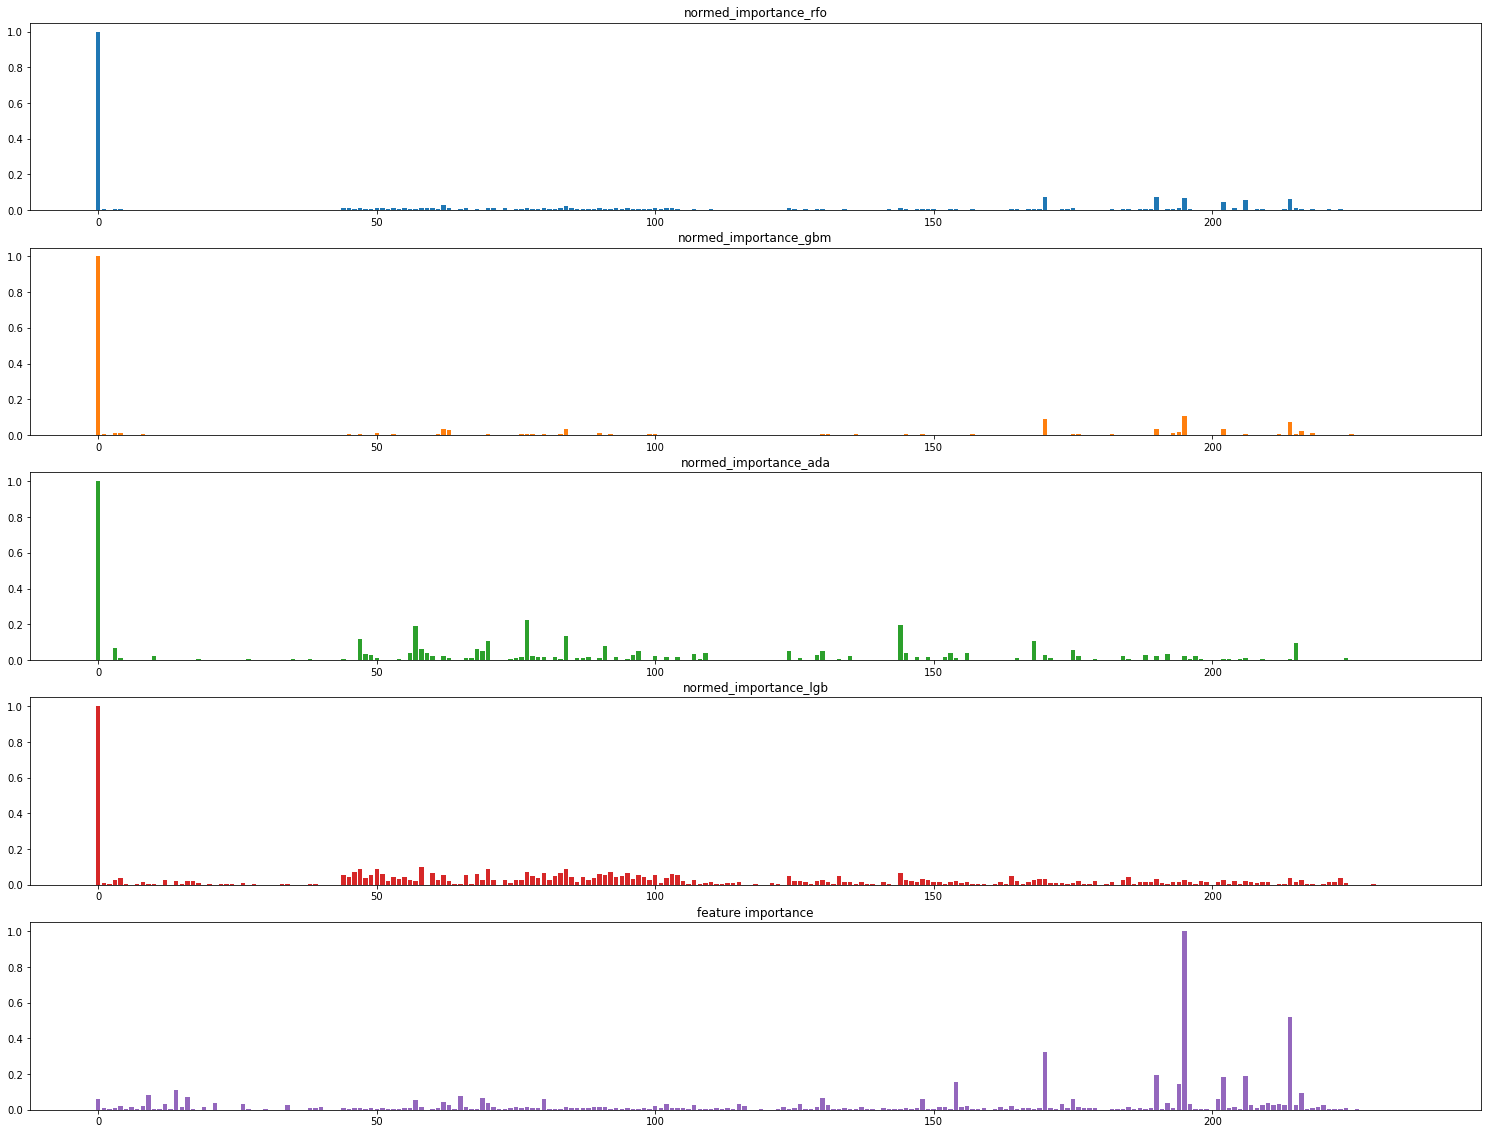

In [524]:

len_new_all_cols = len(new_all_cols)

fig, axs = plt.subplots(len_new_all_cols,1, figsize=(26,20))

axs =axs.reshape(len_new_all_cols)

colors = ['C'+str(e) for e in range(len_new_all_cols)]

n = 0
for col in new_all_cols:
    ax=axs[n]
    xx = pdf_co.reset_index().index.values
    yy = pdf_co[col].values
    ax.bar(xx,yy, color=colors[n])
    
    ax.set_title(col)
    n+=1
    
plt.title(f"feature importance")
plt.show()

Filtering out the NANs

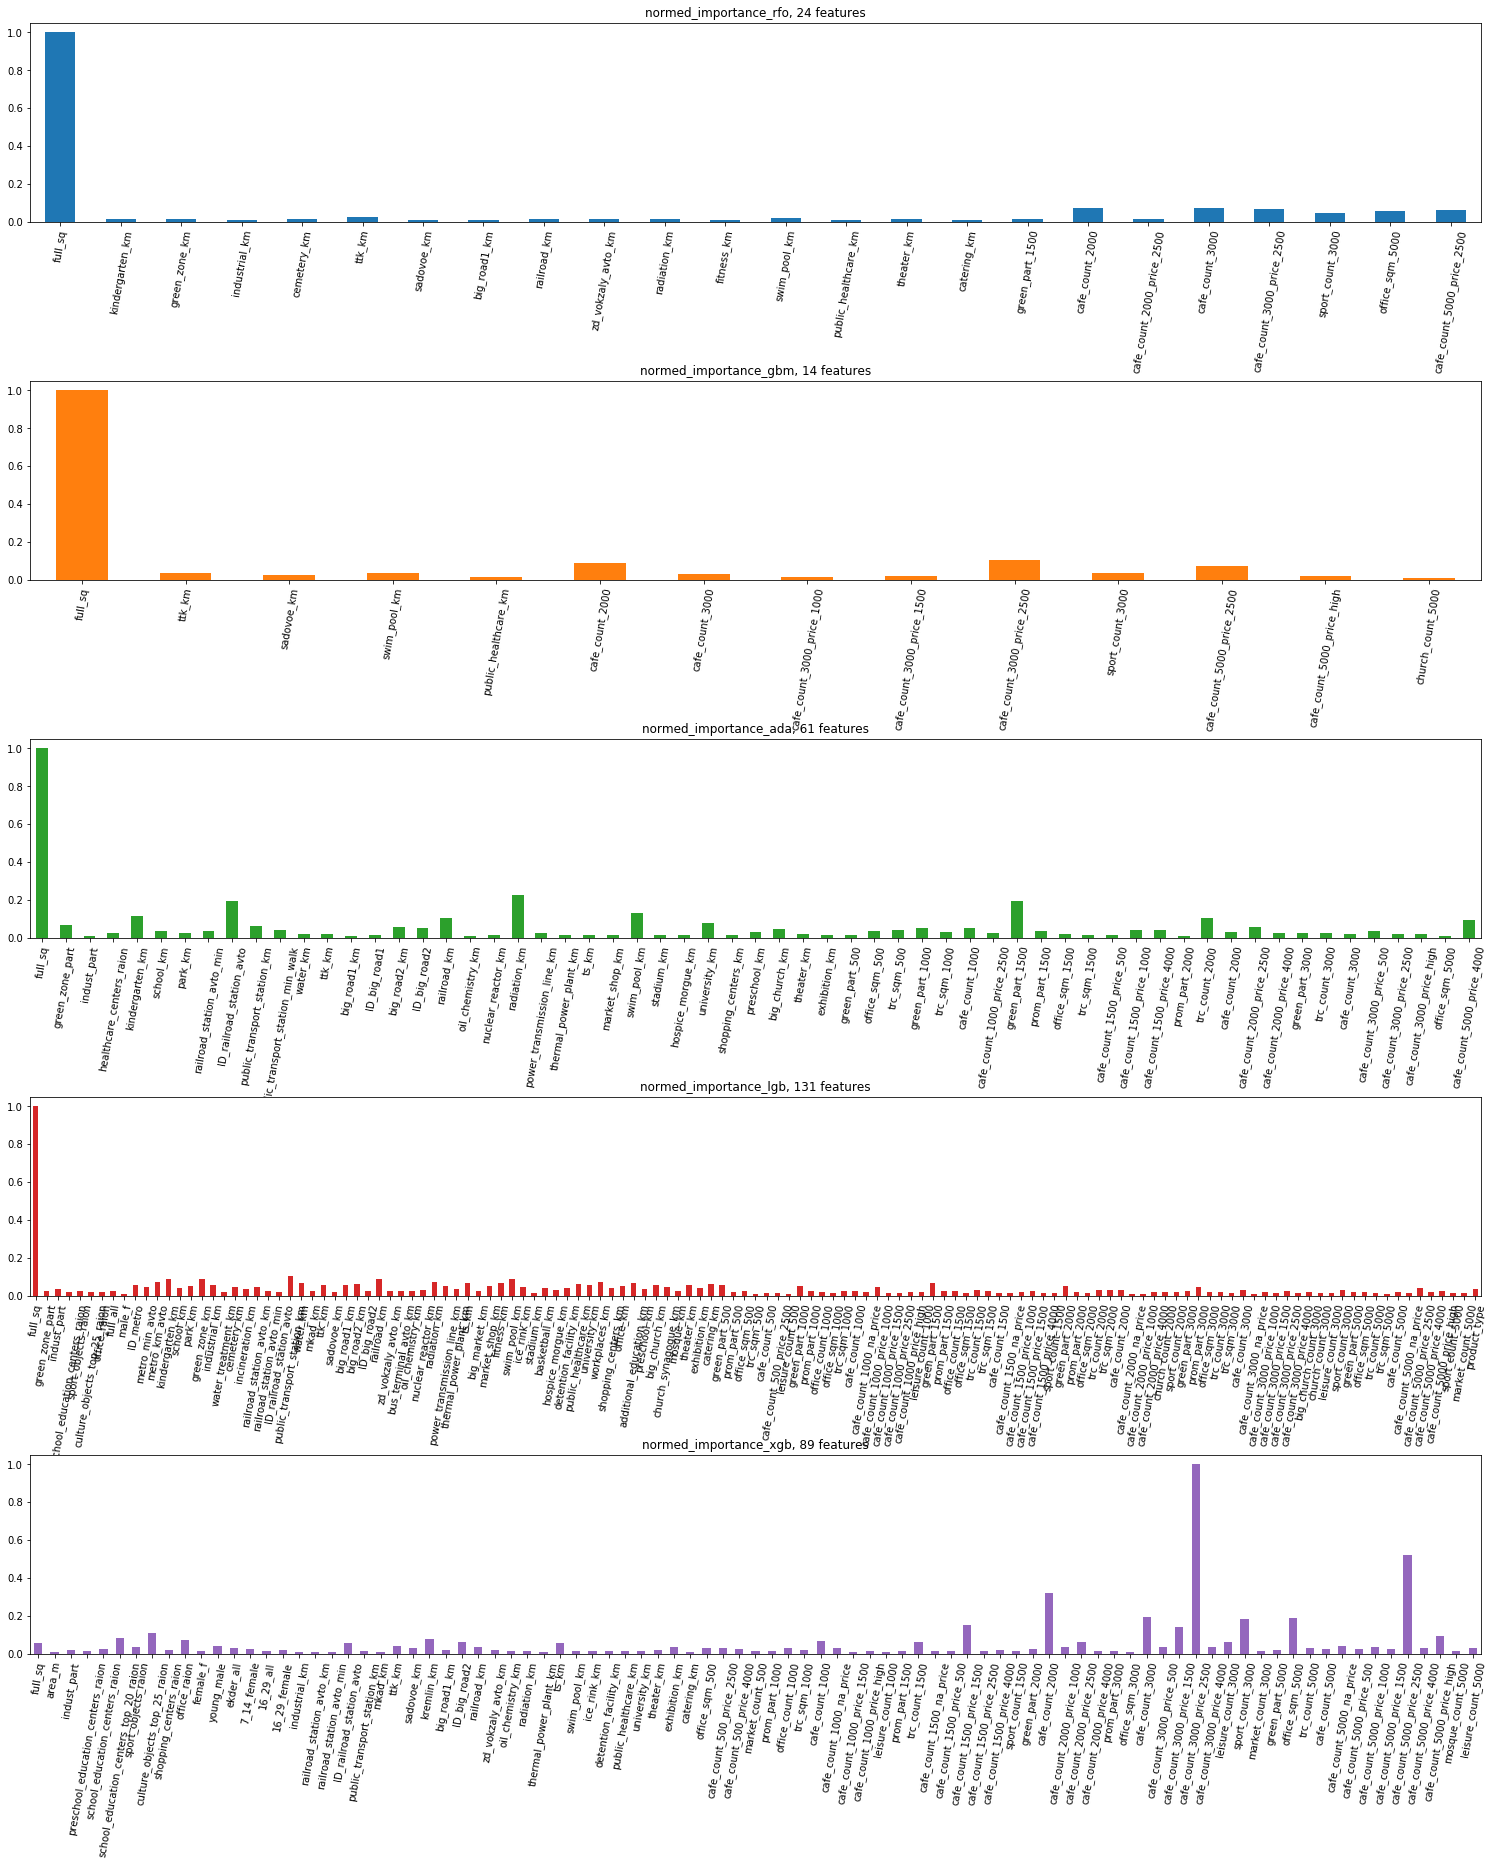

In [536]:
fig, axs = plt.subplots(len_new_all_cols,1, figsize=(26,30))
plt.subplots_adjust( hspace = 0.8)

axs =axs.reshape(len_new_all_cols)

n = 0
for col in new_all_cols:
    ax=axs[n]
    pdf_sub = pdf_co[col].where(pdf_co[col].values>0.01).dropna(how='all')
    nr_cols = len(pdf_sub.index.tolist())
    pdf_sub.plot(kind="bar", ax= ax, color=colors[n])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
    ax.set_title(f'{col}, {nr_cols} features')
    n+=1
    
#plt.subplots_adjust( hspace = 0.2)

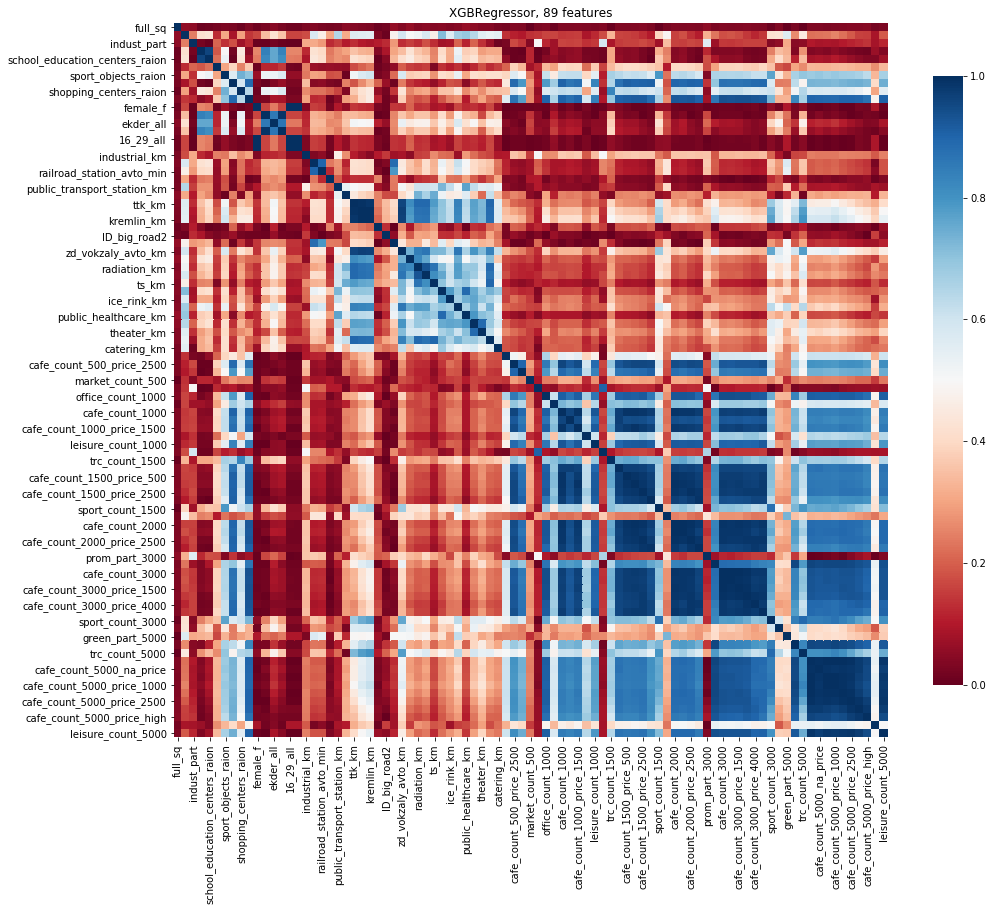

In [595]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 4
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');

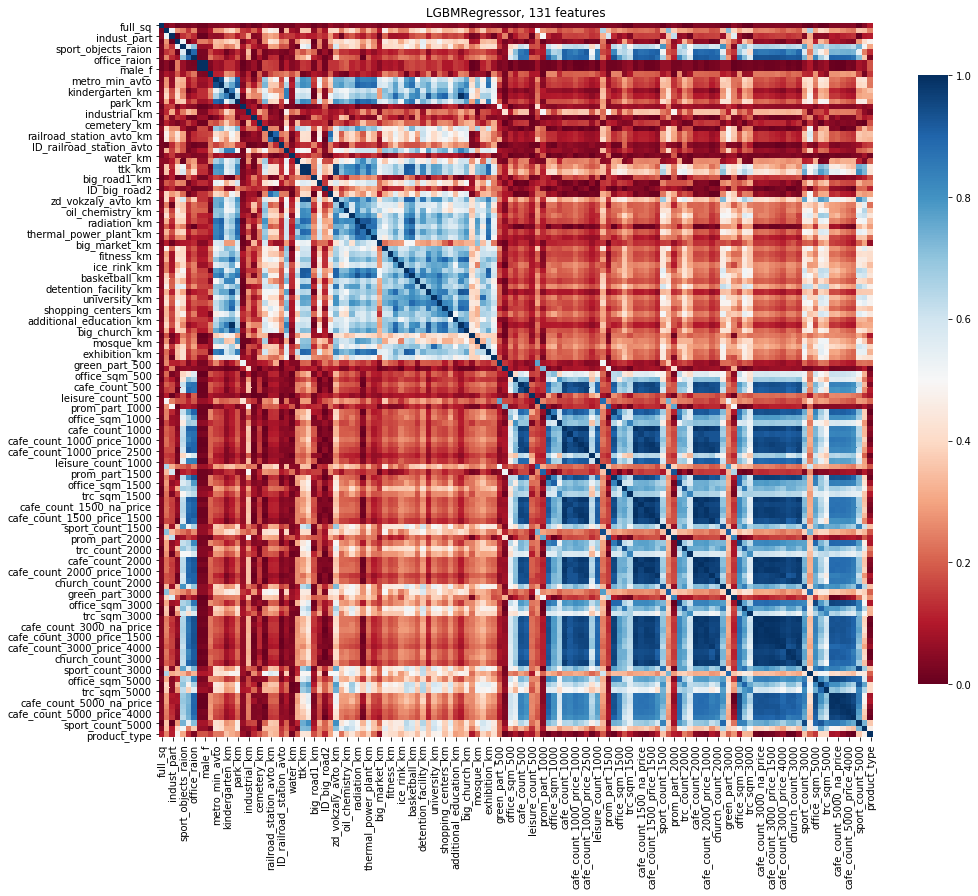

In [594]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 3
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');

#### Note: the remaining features are still mutually correlated

In [568]:
name_to_classif = dict(zip(clf_names, classifiers))

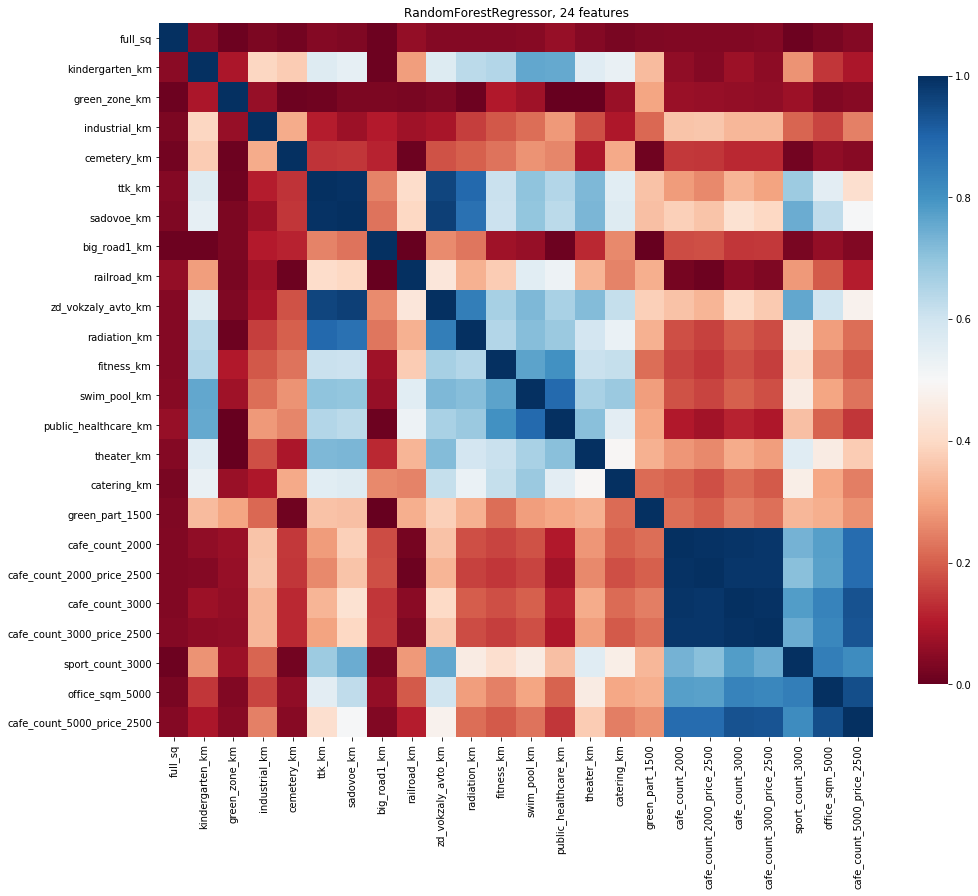

In [591]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 0
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');

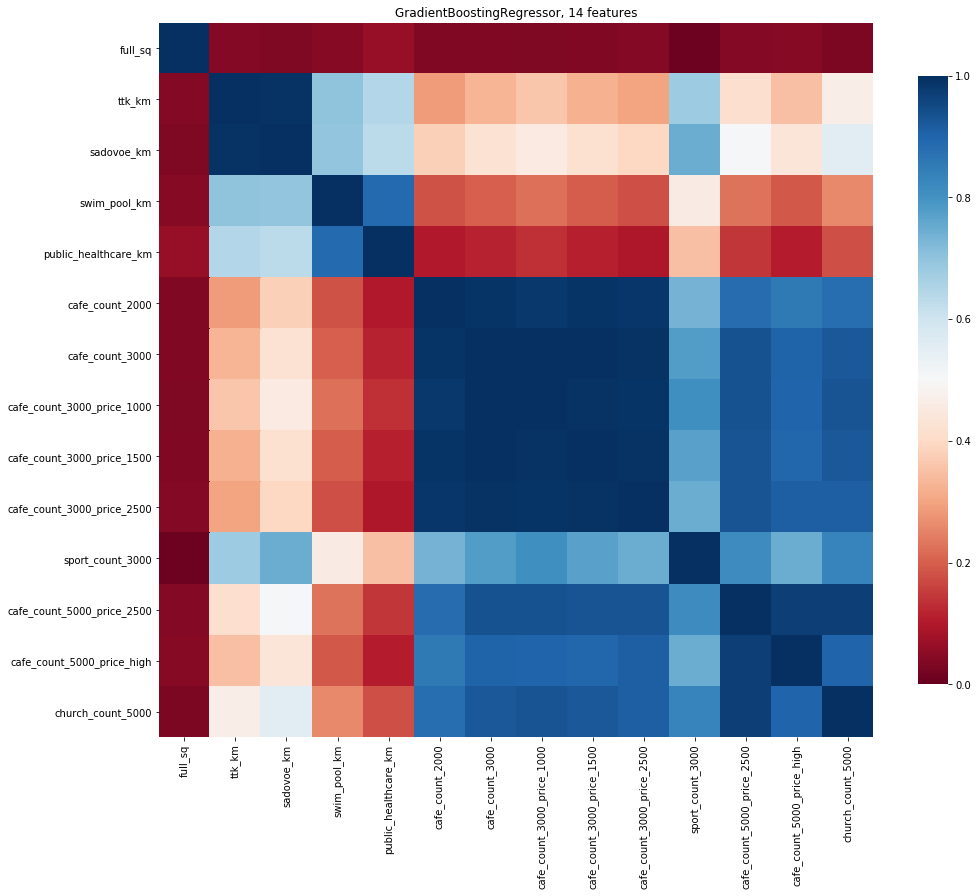

In [592]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 1
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');

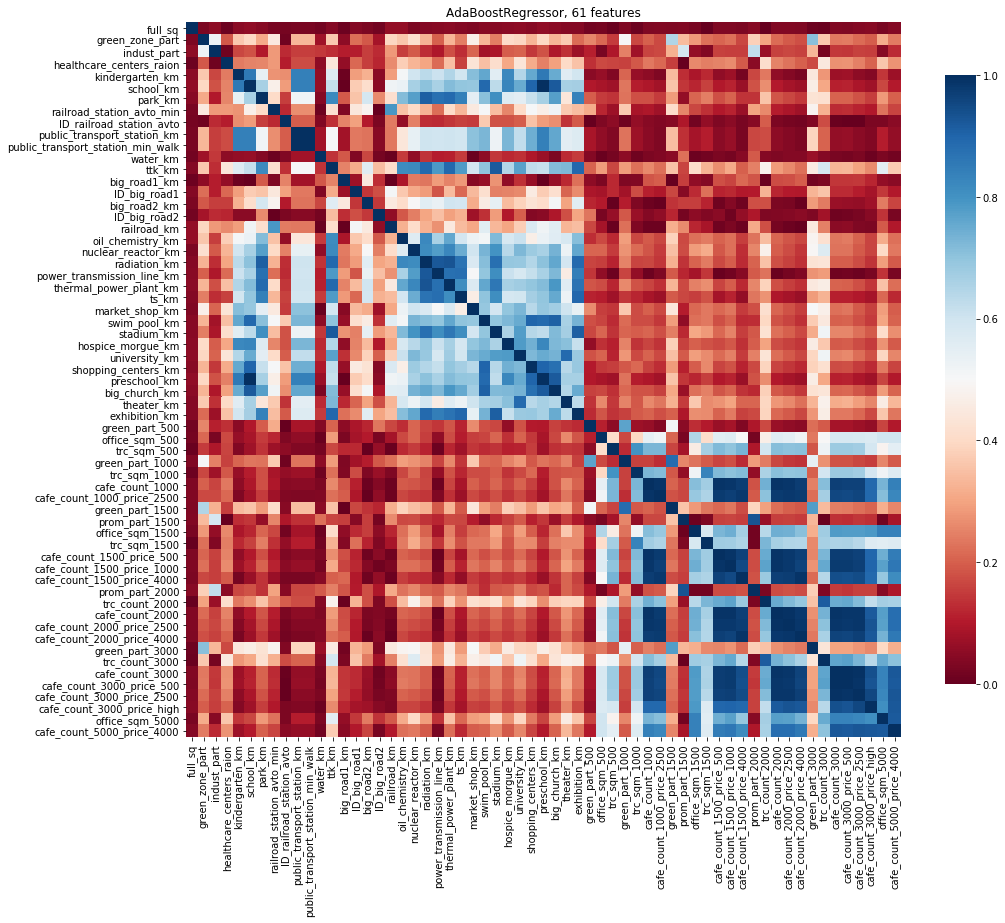

In [593]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 2
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');